In [1]:
import os
seed = 10
os.environ['PYTHONHASHSEED']=str(seed)

In [2]:
import requests
import lxml
import datetime as dt
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.utils import compute_class_weight
import tensorflow as tf
from sklearn import preprocessing

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
np.random.seed(seed)
tf.random.set_seed(seed)

session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1, 
    inter_op_parallelism_threads=1
)
sess = tf.compat.v1.Session(
    graph=tf.compat.v1.get_default_graph(), 
    config=session_conf
)
tf.compat.v1.keras.backend.set_session(sess)

## Cyclic Stocks

### Singapore Airlines

In [5]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14      OBV_7  labels
0  2000-01-21    19.000000  19.215335 -37.499990   388000.0     2.0
1  2000-01-24    18.400000  19.089899 -50.000000 -2311000.0     2.0
2  2000-01-25    18.100000  18.937607 -48.780483 -3542000.0     2.0
3  2000-01-26    17.700001  18.747206 -85.714237 -6261000.0     2.0
4  2000-01-27    17.799999  18.601482 -82.142864 -4565000.0     2.0


In [6]:
df.set_index('Date', inplace=True)

In [7]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [8]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
X.shape

(4735, 5, 4)

In [9]:
v = X.reshape(X.shape[0],5, 4)
v[0]

array([[1.        , 1.        , 1.        , 1.        ],
       [0.53846097, 0.79565763, 0.74074033, 0.5940743 ],
       [0.30769219, 0.54756567, 0.76603403, 0.40893367],
       [0.        , 0.23739236, 0.        , 0.        ],
       [0.07692195, 0.        , 0.07407297, 0.25507595]])

In [10]:
y = labels
y = np.array(y)
y.shape

(4735,)

In [11]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [12]:
SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
RATIO_TO_PREDICT = "Close"

In [13]:
import time

EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [14]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [15]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [16]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 32ms/step - loss: 0.2769 - accuracy: 0.4406 - mse: 0.4621 - weighted_accuracy: 0.3654 - weighted_mse: 0.5034 - val_loss: 0.3007 - val_accuracy: 0.0454 - val_mse: 0.3465 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3465
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.2048 - accuracy: 0.2854 - mse: 0.7814 - weighted_accuracy: 0.5049 - weighted_mse: 0.7388 - val_loss: 0.2916 - val_accuracy: 0.0454 - val_mse: 0.3672 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3672
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1830 - accuracy: 0.2418 - mse: 1.0438 - weighted_accuracy: 0.5444 - weighted_mse: 0.9813 - val_loss: 0.2795 - val_accuracy: 0.0454 - val_mse: 0.3936 - val_weighted_accuracy: 0.0454 - val_weighted_mse: 0.3936
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1744 - accuracy: 0.2323 - mse: 1.2227 - weighted_accuracy: 0.5539 - weighte

Epoch 30/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1393 - accuracy: 0.3955 - mse: 1.6265 - weighted_accuracy: 0.6970 - weighted_mse: 1.5661 - val_loss: 0.1883 - val_accuracy: 0.3474 - val_mse: 1.5999 - val_weighted_accuracy: 0.3474 - val_weighted_mse: 1.5999
Epoch 31/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1384 - accuracy: 0.4118 - mse: 1.6236 - weighted_accuracy: 0.7049 - weighted_mse: 1.5730 - val_loss: 0.1922 - val_accuracy: 0.3495 - val_mse: 1.5597 - val_weighted_accuracy: 0.3495 - val_weighted_mse: 1.5597
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1377 - accuracy: 0.3939 - mse: 1.6500 - weighted_accuracy: 0.7039 - weighted_mse: 1.5900 - val_loss: 0.1869 - val_accuracy: 0.3696 - val_mse: 1.5730 - val_weighted_accuracy: 0.3696 - val_weighted_mse: 1.5730
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1361 - accuracy: 0.4121 - mse: 1.6396 - weighted_accuracy: 0.7032 - weig

Epoch 59/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1164 - accuracy: 0.5502 - mse: 1.9210 - weighted_accuracy: 0.7908 - weighted_mse: 1.9255 - val_loss: 0.1674 - val_accuracy: 0.5238 - val_mse: 1.9047 - val_weighted_accuracy: 0.5238 - val_weighted_mse: 1.9047
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1160 - accuracy: 0.5230 - mse: 1.9692 - weighted_accuracy: 0.7845 - weighted_mse: 1.9537 - val_loss: 0.1742 - val_accuracy: 0.4889 - val_mse: 2.0360 - val_weighted_accuracy: 0.4889 - val_weighted_mse: 2.0360
Epoch 61/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1152 - accuracy: 0.5731 - mse: 1.9376 - weighted_accuracy: 0.8011 - weighted_mse: 1.9415 - val_loss: 0.1891 - val_accuracy: 0.4329 - val_mse: 2.0945 - val_weighted_accuracy: 0.4329 - val_weighted_mse: 2.0945
Epoch 62/200
30/30 [==============================] - 0s 5ms/step - loss: 0.1129 - accuracy: 0.5510 - mse: 1.9881 - weighted_accuracy: 0.8021 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0939 - accuracy: 0.6610 - mse: 2.4572 - weighted_accuracy: 0.8517 - weighted_mse: 2.5167 - val_loss: 0.1739 - val_accuracy: 0.5502 - val_mse: 2.5890 - val_weighted_accuracy: 0.5502 - val_weighted_mse: 2.5890
Epoch 89/200
30/30 [==============================] - 0s 5ms/step - loss: 0.0936 - accuracy: 0.6695 - mse: 2.4708 - weighted_accuracy: 0.8604 - weighted_mse: 2.5280 - val_loss: 0.1819 - val_accuracy: 0.5322 - val_mse: 2.6808 - val_weighted_accuracy: 0.5322 - val_weighted_mse: 2.6808
Epoch 90/200
30/30 [==============================] - 0s 5ms/step - loss: 0.0935 - accuracy: 0.6748 - mse: 2.5399 - weighted_accuracy: 0.8586 - weighted_mse: 2.5935 - val_loss: 0.1906 - val_accuracy: 0.5037 - val_mse: 2.6391 - val_weighted_accuracy: 0.5037 - val_weighted_mse: 2.6391
Epoch 91/200
30/30 [==============================] - 0s 5ms/step - loss: 0.0936 - accuracy: 0.6595 - mse: 2.5133 - weighted_accuracy: 0.8531 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0747 - accuracy: 0.7614 - mse: 3.1939 - weighted_accuracy: 0.8959 - weighted_mse: 3.2405 - val_loss: 0.1877 - val_accuracy: 0.5935 - val_mse: 3.4282 - val_weighted_accuracy: 0.5935 - val_weighted_mse: 3.4282
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0739 - accuracy: 0.7571 - mse: 3.2401 - weighted_accuracy: 0.8981 - weighted_mse: 3.2847 - val_loss: 0.1574 - val_accuracy: 0.6705 - val_mse: 3.3189 - val_weighted_accuracy: 0.6705 - val_weighted_mse: 3.3189
Epoch 119/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0732 - accuracy: 0.7582 - mse: 3.2490 - weighted_accuracy: 0.9022 - weighted_mse: 3.3081 - val_loss: 0.1427 - val_accuracy: 0.7170 - val_mse: 3.2373 - val_weighted_accuracy: 0.7170 - val_weighted_mse: 3.2373
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0731 - accuracy: 0.7722 - mse: 3.2857 - weighted_accuracy: 0.9017 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0613 - accuracy: 0.8139 - mse: 4.2146 - weighted_accuracy: 0.9207 - weighted_mse: 4.1621 - val_loss: 0.1721 - val_accuracy: 0.7043 - val_mse: 4.4590 - val_weighted_accuracy: 0.7043 - val_weighted_mse: 4.4590
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0587 - accuracy: 0.8324 - mse: 4.3495 - weighted_accuracy: 0.9256 - weighted_mse: 4.2401 - val_loss: 0.1704 - val_accuracy: 0.6843 - val_mse: 4.5488 - val_weighted_accuracy: 0.6843 - val_weighted_mse: 4.5488
Epoch 148/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0561 - accuracy: 0.8287 - mse: 4.3596 - weighted_accuracy: 0.9280 - weighted_mse: 4.2524 - val_loss: 0.1565 - val_accuracy: 0.7402 - val_mse: 4.6304 - val_weighted_accuracy: 0.7402 - val_weighted_mse: 4.6304
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0571 - accuracy: 0.8287 - mse: 4.4215 - weighted_accuracy: 0.9243 - 

Epoch 175/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0455 - accuracy: 0.8749 - mse: 5.5998 - weighted_accuracy: 0.9505 - weighted_mse: 5.2993 - val_loss: 0.1641 - val_accuracy: 0.7666 - val_mse: 6.2539 - val_weighted_accuracy: 0.7666 - val_weighted_mse: 6.2539
Epoch 176/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0455 - accuracy: 0.8728 - mse: 5.7025 - weighted_accuracy: 0.9478 - weighted_mse: 5.3571 - val_loss: 0.1769 - val_accuracy: 0.7212 - val_mse: 6.1119 - val_weighted_accuracy: 0.7212 - val_weighted_mse: 6.1119
Epoch 177/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0452 - accuracy: 0.8767 - mse: 5.7256 - weighted_accuracy: 0.9437 - weighted_mse: 5.4052 - val_loss: 0.1754 - val_accuracy: 0.7181 - val_mse: 5.7741 - val_weighted_accuracy: 0.7181 - val_weighted_mse: 5.7741
Epoch 178/200
30/30 [==============================] - 0s 7ms/step - loss: 0.0467 - accuracy: 0.8712 - mse: 5.7501 - weighted_accuracy: 0.9454 - 

In [17]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1667022556066513
Test accuracy: 0.7940865755081177


In [18]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.8551297  -0.47279602  0.5996945 ]
 [-1.3416708  -3.7370837   1.3495071 ]
 [-1.0747184  -4.226645    0.34924433]
 ...
 [-6.5107865  -5.701031    5.2759805 ]
 [-1.1102     -2.9330058   0.28559077]
 [ 0.36897692 -2.8864388  -1.1014879 ]]


Counter({2: 805, 1: 73, 0: 69})

In [19]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 861, 0: 43, 1: 43})

In [20]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 947
actual predicted buys: 8
actual buys but predicted sell: 1
actual buys but predicted hold: 34
actual sells but predicted buy: 2
actual predicted sells: 7
actual sells but predicted hold: 34
actual holds but predicted buy: 63
actual holds but predicted sell: 61
actual predicted holds: 737
Percentage buys correct: 18.6046511627907%
Percentage sells correct: 16.27906976744186%
Percentage holds correct: 85.59814169570267%
actual buys: 43
actual sells: 43
actual holds: 861


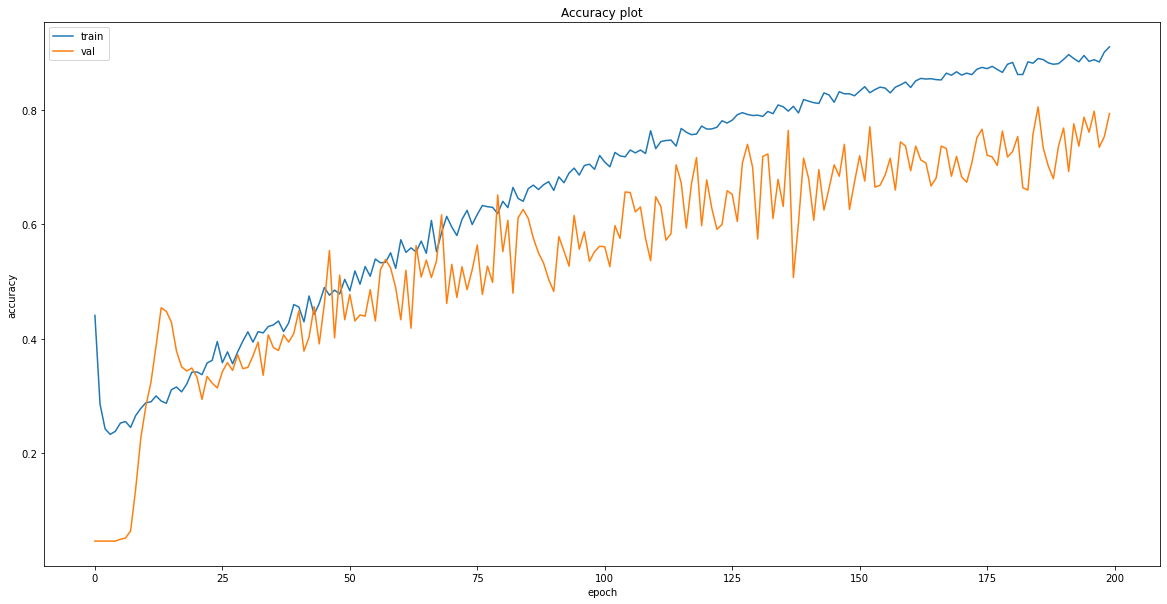

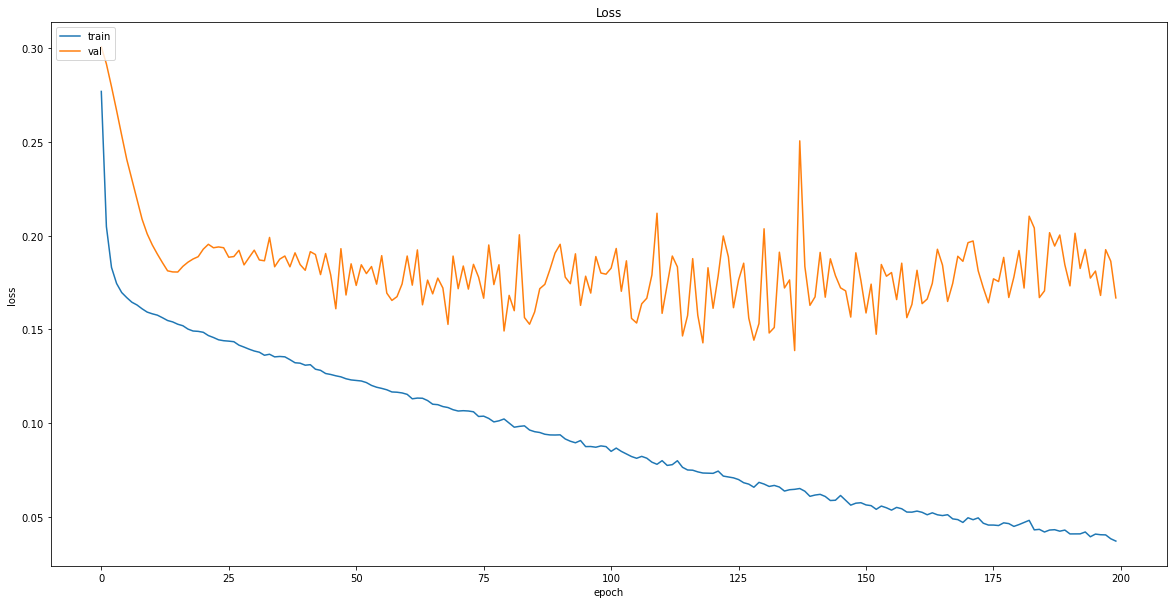

In [21]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [22]:
# Save model
model.save("models/{}".format('Singapore_Airlines_time_series_lstm_buy_hold_sell_5.model'))

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: models/Singapore_Airlines_time_series_lstm_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [23]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2019-02-04         9.63  9.634372 -54.545402  4627100.0     2.0
2019-02-05         9.66  9.638315 -45.454598  5084100.0     2.0
2019-02-07         9.66  9.641651 -45.454598  5084100.0     2.0
2019-02-08         9.66  9.644474 -45.454598  5084100.0     2.0
2019-02-11         9.76  9.662247 -15.151533  6464788.0     2.0


In [24]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [25]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(218, 5, 4)

In [26]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [27]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1603 - accuracy: 0.8165 - mean_squared_error: 7.0005 - weighted_accuracy: 0.8165 - weighted_mean_squared_error: 7.0005
Test loss: 0.1602615863084793
Test accuracy: 0.8165137767791748


In [28]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 190, 0: 11, 1: 17})

In [29]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 200, 0: 9, 1: 9})

In [30]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,9.71,9.662247,-15.151533,6464788.0,2.0,2,2
2019-02-12,9.65,9.669594,-30.303065,5675088.0,2.0,2,2
2019-02-13,9.73,9.666579,-48.484962,4337188.0,2.0,2,2
2019-02-14,9.87,9.676336,-32.000351,5826588.0,2.0,2,2
2019-02-15,9.76,9.706131,-6.250130,8384988.0,2.0,0,2


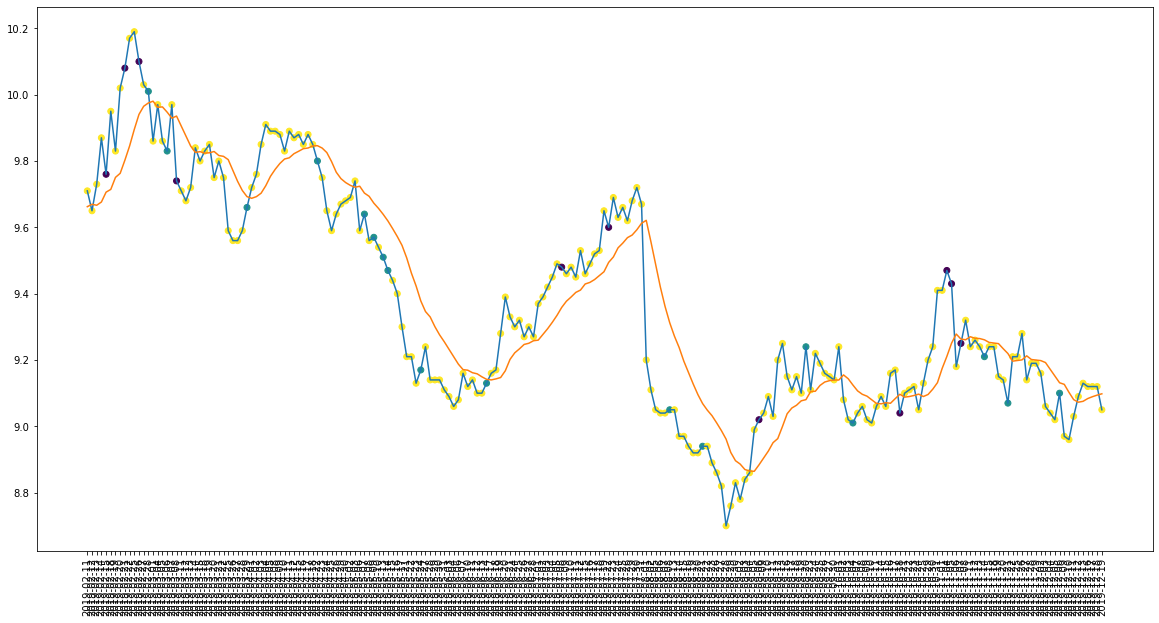

In [31]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [32]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 8
actual holds but predicted buy: 15
actual holds but predicted sell: 10
actual predicted holds: 175
Percentage buys correct: 22.22222222222222%
Percentage sells correct: 11.11111111111111%
Percentage holds correct: 87.5%
actual buys: 9
actual sells: 9
actual holds: 200


In [33]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 29.41176470588235%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 79.36507936507937%


In [34]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[9.649999618530273, 9.710000038146973, 9.729999542236328, 9.760000228881836, 9.829999923706056, 9.869999885559082, 9.949999809265137, 10.020000457763672, 10.079999923706056]
[9.829999923706056, 9.859999656677246, 10.010000228881836, 10.020000457763672, 10.029999732971193, 10.079999923706056, 10.100000381469727, 10.170000076293944, 10.1899995803833]
Percentage buys correct: 29.41176470588235%
Percentage sells correct: 45.45454545454545%
Percentage holds correct: 79.36507936507937%


In [35]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.010000228881836
Shares owned at the moment: 996
Cash capital at the moment: $2.622381406783461


Stop Loss Activated!

Share price: $9.710000038146973
Shares owned at the moment: 0
Cash capital at the moment: $9647.186729296684


Share price: $9.65999984741211
Shares owned at the moment: 995
Cash capital at the moment: $9.054706539152903


Stop Loss Activated!

Share price: $9.300000190734863
Shares owned at the moment: 0
Cash capital at the moment: $9237.107770798444


Share price: $9.170000076293944
Shares owned at the moment: 1004
Cash capital at the moment: $5.1093239886777155


Stop Loss Activated!

Share price: $8.890000343322754
Shares owned at the moment: 0
Cash capital at the moment: $8906.124377736809


Share price: $9.239999771118164
Shares owned at the moment: 961
Cash capital at the moment: $2.0655882971313986


Stop Loss Activated!

Share price: $8.970000267028809
Shares owned at the moment: 0
Cash capital at the moment: $8598.530376706125




Capital at 

In [36]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9269.197226061342
profit gained: -7.30802773938658%


### Recession

In [37]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/C6L.SI_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
print(df.head())

            previous_1d    EMA_12   willr_14      OBV_7  labels
Date                                                           
2020-02-06         8.59  8.669432 -78.124958 -1004100.0     0.0
2020-02-07         8.74  8.680288 -53.968268  1419800.0     2.0
2020-02-10         8.58  8.664859 -78.333328 -1778600.0     2.0
2020-02-11         8.51  8.641035 -89.830440 -3476200.0     2.0
2020-02-12         8.53  8.623953 -86.440694 -2356000.0     2.0


In [38]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [39]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(215, 5, 4)

In [40]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [41]:
model = tf.keras.models.load_model("models/Singapore_Airlines_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1448 - accuracy: 0.8279 - mean_squared_error: 6.6078 - weighted_accuracy: 0.8279 - weighted_mean_squared_error: 6.6078
Test loss: 0.14476056396961212
Test accuracy: 0.8279069662094116


In [42]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 191, 1: 19, 0: 5})

In [43]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [44]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,8.64,8.623953,-86.440694,-2356000.0,2.0,2,2
2020-02-13,8.59,8.626421,-61.224363,-575600.0,2.0,2,2
2020-02-14,8.62,8.620818,-64.102508,-2132700.0,2.0,2,2
2020-02-17,8.66,8.620692,-45.161340,-798700.0,2.0,2,2
2020-02-18,8.51,8.626740,-32.258144,341600.0,2.0,2,2


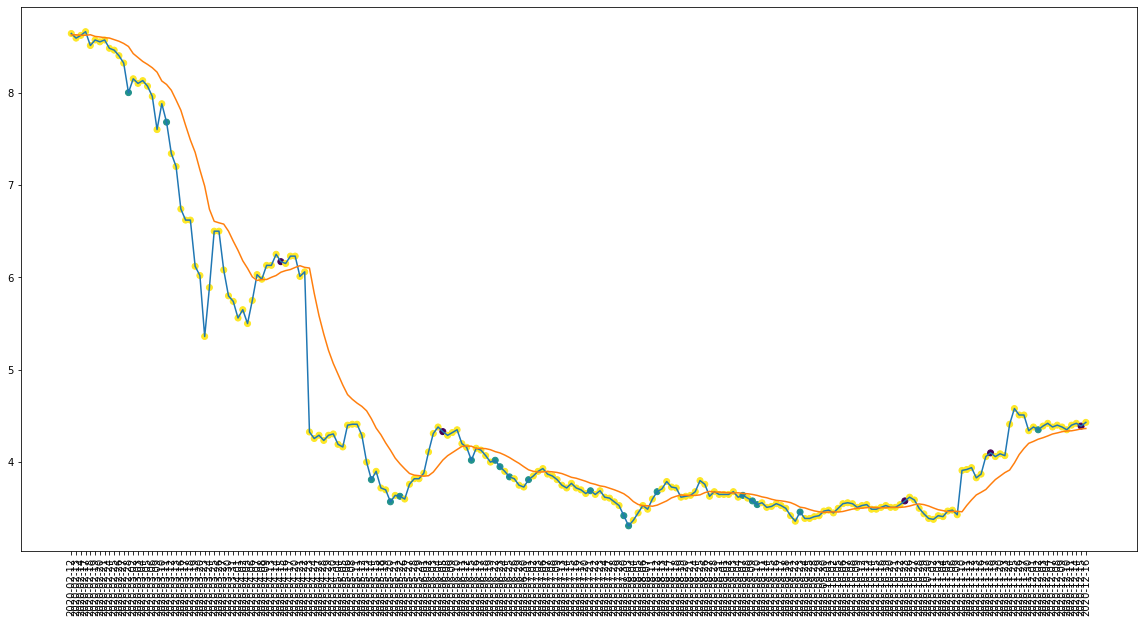

In [45]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [46]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 2
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 9
actual holds but predicted buy: 17
actual holds but predicted sell: 5
actual predicted holds: 176
Percentage buys correct: 25.0%
Percentage sells correct: 0.0%
Percentage holds correct: 88.88888888888889%
actual buys: 8
actual sells: 9
actual holds: 198


In [47]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[8.479999542236326, 8.510000228881836, 8.550000190734862, 8.569999694824219, 8.569999694824219, 8.590000152587889, 8.619999885559082, 8.640000343322754, 8.659999847412111]
[8.0, 8.100000381469728, 8.149999618530272, 8.319999694824219, 8.399999618530272, 8.460000038146973, 8.479999542236326, 8.550000190734862, 8.569999694824219]
Percentage buys correct: 52.63157894736842%
Percentage sells correct: 100.0%
Percentage holds correct: 85.26315789473684%


In [48]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $8.0
Shares owned at the moment: 1246
Cash capital at the moment: $4.587999999999738


Stop Loss Activated!

Share price: $7.599999904632567
Shares owned at the moment: 0
Cash capital at the moment: $9448.146481498954


Share price: $7.679999828338622
Shares owned at the moment: 1226
Cash capital at the moment: $6.573572534560299


Stop Loss Activated!

Share price: $7.3400001525878915
Shares owned at the moment: 0
Cash capital at the moment: $8980.666949092865


Share price: $3.809999942779541
Shares owned at the moment: 2350
Cash capital at the moment: $2.5449589307299902


Stop Loss Activated!

Share price: $3.700000047683716
Shares owned at the moment: 0
Cash capital at the moment: $8673.633820679306


Share price: $3.5699999332427983
Shares owned at the moment: 2422
Cash capital at the moment: $3.3159978098847205


Price increase from previously bought: 20.95588684827856%
Share price: $4.329999923706056
Shares owned at the moment: 0
Cash capital at the moment: $10461.

In [49]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5100.181760163545
profit gained: -48.998182398364555%


### OCBC Bank

In [50]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14      OBV_7  labels
0  2000-01-21     6.793788  7.018572 -90.000010 -1965914.0     2.0
1  2000-01-24     6.890842  6.998922 -77.777802  6276910.0     2.0
2  2000-01-25     6.793788  6.967363 -85.714286  -511055.0     2.0
3  2000-01-26     6.745261  6.933193 -86.666549 -7435027.0     2.0
4  2000-01-27     6.890842  6.926678 -66.666601 -3725757.0     2.0


In [51]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,6.793788,7.018572,-90.000010,-1965914.0,2.0
2000-01-24,6.890842,6.998922,-77.777802,6276910.0,2.0
2000-01-25,6.793788,6.967363,-85.714286,-511055.0,2.0
2000-01-26,6.745261,6.933193,-86.666549,-7435027.0,2.0
2000-01-27,6.890842,6.926678,-66.666601,-3725757.0,2.0


In [52]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [53]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
X.shape

(4799, 5, 4)

In [54]:
y = labels
y = np.array(y)

In [55]:
X[0]

array([[0.33333224, 1.        , 0.        , 0.3988578 ],
       [1.        , 0.78615952, 0.52380721, 1.        ],
       [0.33333224, 0.44273426, 0.1836733 , 0.50495944],
       [0.        , 0.07090238, 0.14286216, 0.        ],
       [1.        , 0.        , 1.        , 0.27051393]])

In [56]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [57]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [58]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [59]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [60]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 0 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 29ms/step - loss: 0.2740 - accuracy: 0.4259 - mse: 0.4664 - weighted_accuracy: 0.3957 - weighted_mse: 0.4896 - val_loss: 0.3007 - val_accuracy: 0.0417 - val_mse: 0.3467 - val_weighted_accuracy: 0.0417 - val_weighted_mse: 0.3467
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.2009 - accuracy: 0.2740 - mse: 0.7819 - weighted_accuracy: 0.5333 - weighted_mse: 0.7248 - val_loss: 0.2922 - val_accuracy: 0.0417 - val_mse: 0.3699 - val_weighted_accuracy: 0.0417 - val_weighted_mse: 0.3699
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1778 - accuracy: 0.2266 - mse: 1.0398 - weighted_accuracy: 0.5609 - weighted_mse: 0.9705 - val_loss: 0.2805 - val_accuracy: 0.0417 - val_mse: 0.3968 - val_weighted_accuracy: 0.0417 - val_weighted_mse: 0.3968
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1682 - accuracy: 0.2287 - mse: 1.2257 - weighted_accuracy: 0.5881 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1294 - accuracy: 0.4298 - mse: 1.9008 - weighted_accuracy: 0.7226 - weighted_mse: 1.8394 - val_loss: 0.1862 - val_accuracy: 0.3823 - val_mse: 1.8517 - val_weighted_accuracy: 0.3823 - val_weighted_mse: 1.8517
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1284 - accuracy: 0.4345 - mse: 1.9070 - weighted_accuracy: 0.7285 - weighted_mse: 1.8492 - val_loss: 0.1810 - val_accuracy: 0.4083 - val_mse: 1.8467 - val_weighted_accuracy: 0.4083 - val_weighted_mse: 1.8467
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1272 - accuracy: 0.4467 - mse: 1.9287 - weighted_accuracy: 0.7290 - weighted_mse: 1.8728 - val_loss: 0.1872 - val_accuracy: 0.3833 - val_mse: 1.9473 - val_weighted_accuracy: 0.3833 - val_weighted_mse: 1.9473
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1272 - accuracy: 0.4478 - mse: 1.9561 - weighted_accuracy: 0.7276 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1074 - accuracy: 0.5757 - mse: 2.3548 - weighted_accuracy: 0.8139 - weighted_mse: 2.3436 - val_loss: 0.1974 - val_accuracy: 0.4229 - val_mse: 2.4906 - val_weighted_accuracy: 0.4229 - val_weighted_mse: 2.4906
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1057 - accuracy: 0.5866 - mse: 2.4115 - weighted_accuracy: 0.8176 - weighted_mse: 2.4325 - val_loss: 0.1696 - val_accuracy: 0.5302 - val_mse: 2.4698 - val_weighted_accuracy: 0.5302 - val_weighted_mse: 2.4698
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1058 - accuracy: 0.5817 - mse: 2.3989 - weighted_accuracy: 0.8152 - weighted_mse: 2.3893 - val_loss: 0.1686 - val_accuracy: 0.5146 - val_mse: 2.4271 - val_weighted_accuracy: 0.5146 - val_weighted_mse: 2.4271
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1034 - accuracy: 0.5921 - mse: 2.4323 - weighted_accuracy: 0.8160 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0866 - accuracy: 0.6984 - mse: 3.1271 - weighted_accuracy: 0.8670 - weighted_mse: 3.1571 - val_loss: 0.1690 - val_accuracy: 0.5760 - val_mse: 3.2640 - val_weighted_accuracy: 0.5760 - val_weighted_mse: 3.2640
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0856 - accuracy: 0.6973 - mse: 3.1810 - weighted_accuracy: 0.8691 - weighted_mse: 3.2297 - val_loss: 0.1654 - val_accuracy: 0.6042 - val_mse: 3.2597 - val_weighted_accuracy: 0.6042 - val_weighted_mse: 3.2597
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0851 - accuracy: 0.6885 - mse: 3.1779 - weighted_accuracy: 0.8675 - weighted_mse: 3.1961 - val_loss: 0.1720 - val_accuracy: 0.5948 - val_mse: 3.2489 - val_weighted_accuracy: 0.5948 - val_weighted_mse: 3.2489
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0833 - accuracy: 0.7090 - mse: 3.2010 - weighted_accuracy: 0.8790 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0705 - accuracy: 0.7697 - mse: 4.2874 - weighted_accuracy: 0.8936 - weighted_mse: 4.2338 - val_loss: 0.1728 - val_accuracy: 0.6417 - val_mse: 4.5035 - val_weighted_accuracy: 0.6417 - val_weighted_mse: 4.5035
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0683 - accuracy: 0.7742 - mse: 4.2519 - weighted_accuracy: 0.9010 - weighted_mse: 4.2220 - val_loss: 0.1575 - val_accuracy: 0.6740 - val_mse: 4.4861 - val_weighted_accuracy: 0.6740 - val_weighted_mse: 4.4861
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0677 - accuracy: 0.7846 - mse: 4.3770 - weighted_accuracy: 0.9026 - weighted_mse: 4.3453 - val_loss: 0.1819 - val_accuracy: 0.6333 - val_mse: 4.6394 - val_weighted_accuracy: 0.6333 - val_weighted_mse: 4.6394
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0665 - accuracy: 0.7781 - mse: 4.3855 - weighted_accuracy: 0.9114 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0544 - accuracy: 0.8320 - mse: 5.6749 - weighted_accuracy: 0.9293 - weighted_mse: 5.3714 - val_loss: 0.1664 - val_accuracy: 0.7104 - val_mse: 6.0230 - val_weighted_accuracy: 0.7104 - val_weighted_mse: 6.0230
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0555 - accuracy: 0.8278 - mse: 5.7446 - weighted_accuracy: 0.9313 - weighted_mse: 5.4890 - val_loss: 0.1927 - val_accuracy: 0.6635 - val_mse: 6.0940 - val_weighted_accuracy: 0.6635 - val_weighted_mse: 6.0940
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0540 - accuracy: 0.8223 - mse: 5.7661 - weighted_accuracy: 0.9202 - weighted_mse: 5.5469 - val_loss: 0.1506 - val_accuracy: 0.7604 - val_mse: 6.3335 - val_weighted_accuracy: 0.7604 - val_weighted_mse: 6.3335
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0547 - accuracy: 0.8294 - mse: 5.8823 - weighted_accuracy: 0.9263 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0441 - accuracy: 0.8705 - mse: 7.4638 - weighted_accuracy: 0.9473 - weighted_mse: 6.8854 - val_loss: 0.1673 - val_accuracy: 0.7417 - val_mse: 8.0865 - val_weighted_accuracy: 0.7417 - val_weighted_mse: 8.0865
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0448 - accuracy: 0.8656 - mse: 7.5730 - weighted_accuracy: 0.9451 - weighted_mse: 6.9629 - val_loss: 0.1727 - val_accuracy: 0.7625 - val_mse: 7.5823 - val_weighted_accuracy: 0.7625 - val_weighted_mse: 7.5823
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0446 - accuracy: 0.8698 - mse: 7.6136 - weighted_accuracy: 0.9449 - weighted_mse: 7.0155 - val_loss: 0.1844 - val_accuracy: 0.7125 - val_mse: 8.1094 - val_weighted_accuracy: 0.7125 - val_weighted_mse: 8.1094
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0468 - accuracy: 0.8651 - mse: 7.6299 - weighted_accuracy: 0.9376 - 

In [61]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1887938529253006
Test accuracy: 0.75


In [62]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.5027375  -2.6244552   1.6698257 ]
 [-4.984926   -0.5643383   0.24328972]
 [-1.7771751  -4.5736256   1.3834766 ]
 ...
 [-3.62497    -5.032056    3.0496247 ]
 [-4.150994   -4.3925104   3.1345701 ]
 [-2.4826887  -2.3645015   1.657624  ]]


Counter({2: 766, 0: 107, 1: 87})

In [63]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 876, 1: 40, 0: 44})

In [64]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 960
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 34
actual sells but predicted buy: 1
actual predicted sells: 13
actual sells but predicted hold: 30
actual holds but predicted buy: 81
actual holds but predicted sell: 93
actual predicted holds: 702
Percentage buys correct: 12.5%
Percentage sells correct: 29.545454545454547%
Percentage holds correct: 80.13698630136986%
actual buys: 40
actual sells: 44
actual holds: 876


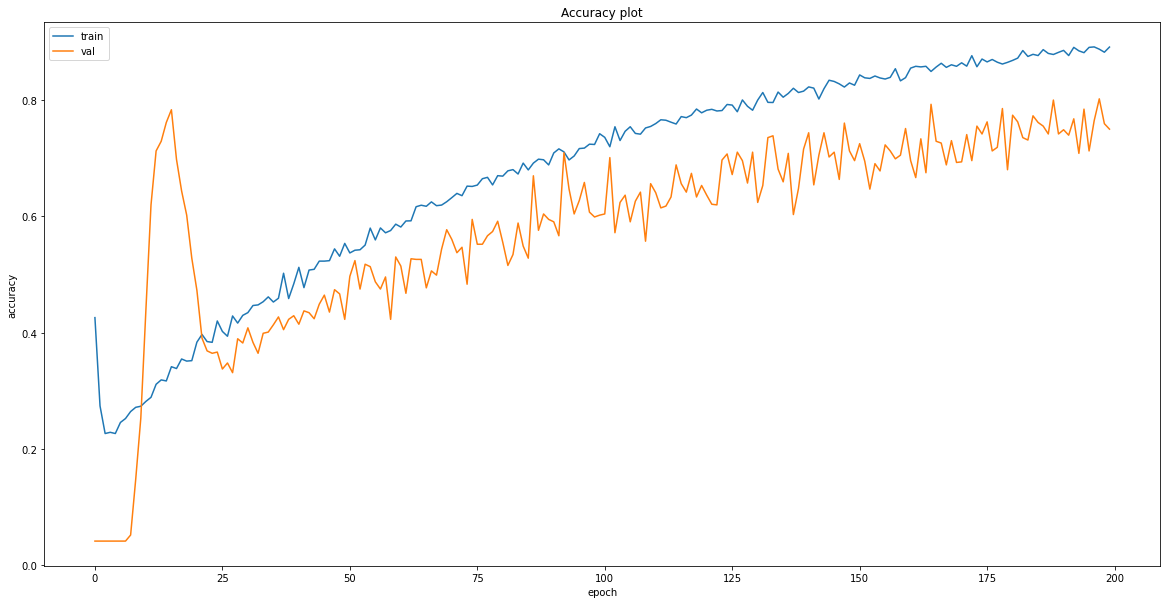

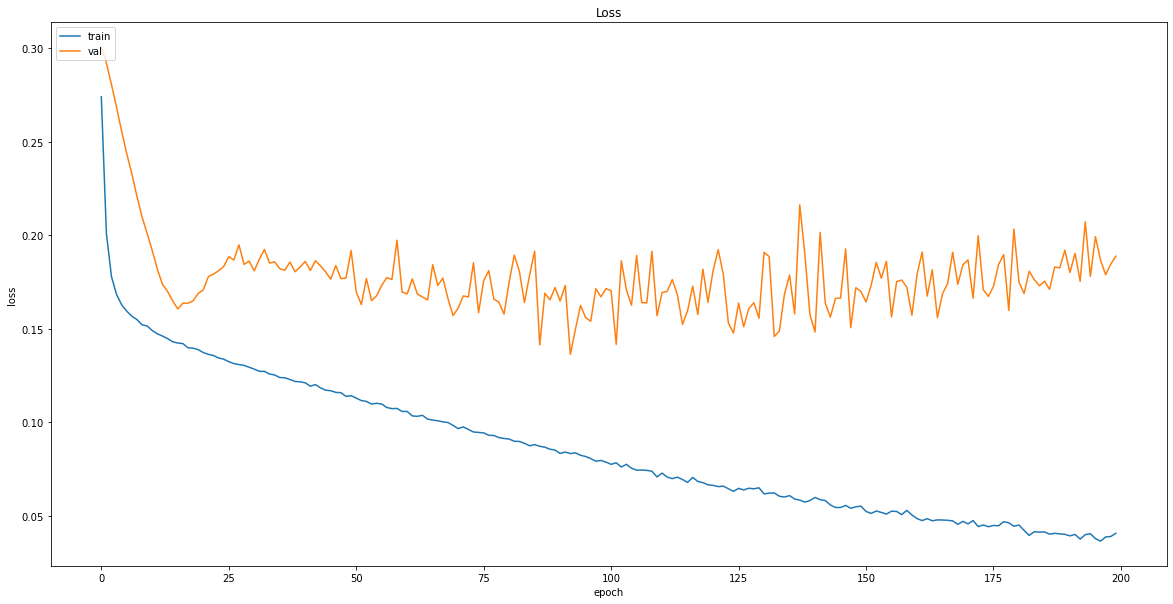

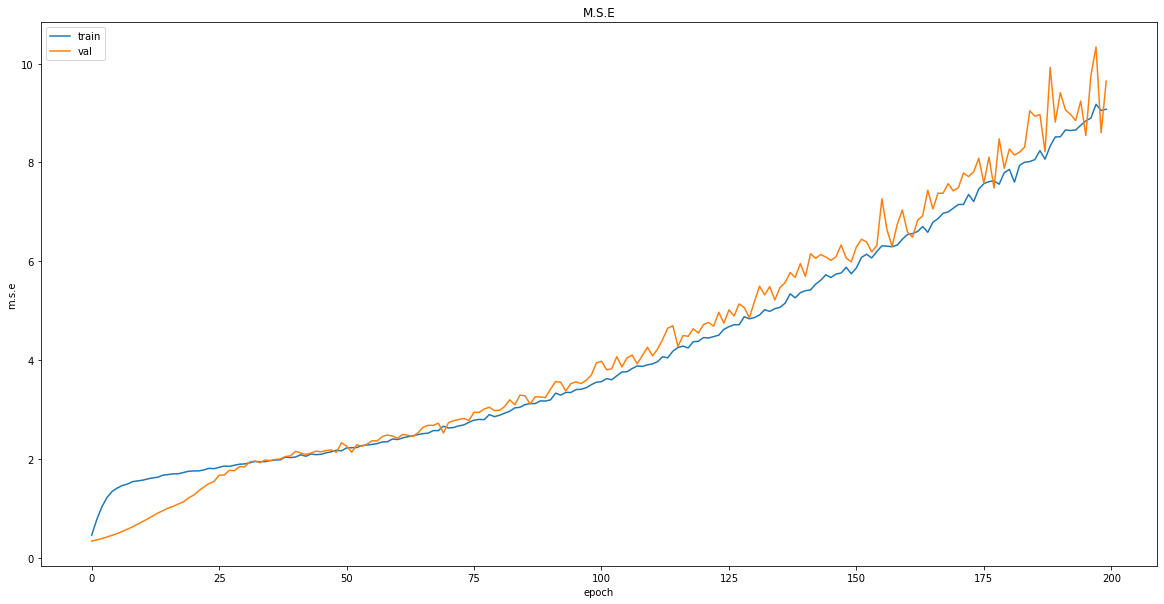

In [65]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['mse'])
plt.plot(history.history['val_mse'])
plt.title('M.S.E')
plt.ylabel('m.s.e')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [66]:
# Save model
model.save("models/{}".format('ocbc_time_series_lstm_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/ocbc_time_series_lstm_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [67]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2019-02-04        11.45  11.473251 -73.214328  19702751.0     1.0
2019-02-05        11.38  11.458905 -85.714286  17849651.0     2.0
2019-02-07        11.38  11.446765 -85.714286  17849651.0     2.0
2019-02-08        11.49  11.453417 -66.071471  20418651.0     2.0
2019-02-11        11.48  11.457507 -67.857228  17615658.0     2.0


In [68]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [69]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(218, 5, 4)

In [70]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [71]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2620 - accuracy: 0.6743 - mean_squared_error: 8.7667 - weighted_accuracy: 0.6743 - weighted_mean_squared_error: 8.7667
Test loss: 0.2619888484477997
Test accuracy: 0.6743119359016418


In [72]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 160, 0: 34, 1: 24})

In [73]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 201, 0: 9, 1: 8})

In [74]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,11.53,11.457507,-67.857228,17615658.0,2.0,2,2
2019-02-12,11.49,11.468659,-43.902530,20832858.0,2.0,0,2
2019-02-13,11.65,11.471942,-42.424356,17325458.0,2.0,2,2
2019-02-14,11.68,11.499336,-10.256417,22091358.0,2.0,0,2
2019-02-15,11.52,11.527130,-5.714153,24228358.0,2.0,0,2


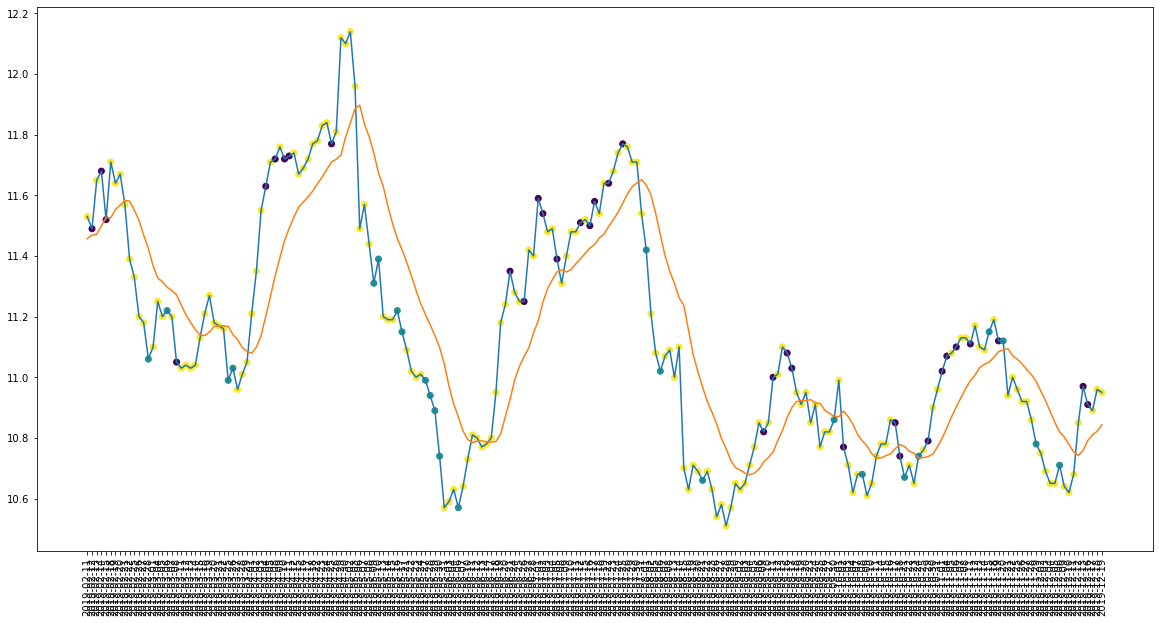

In [75]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

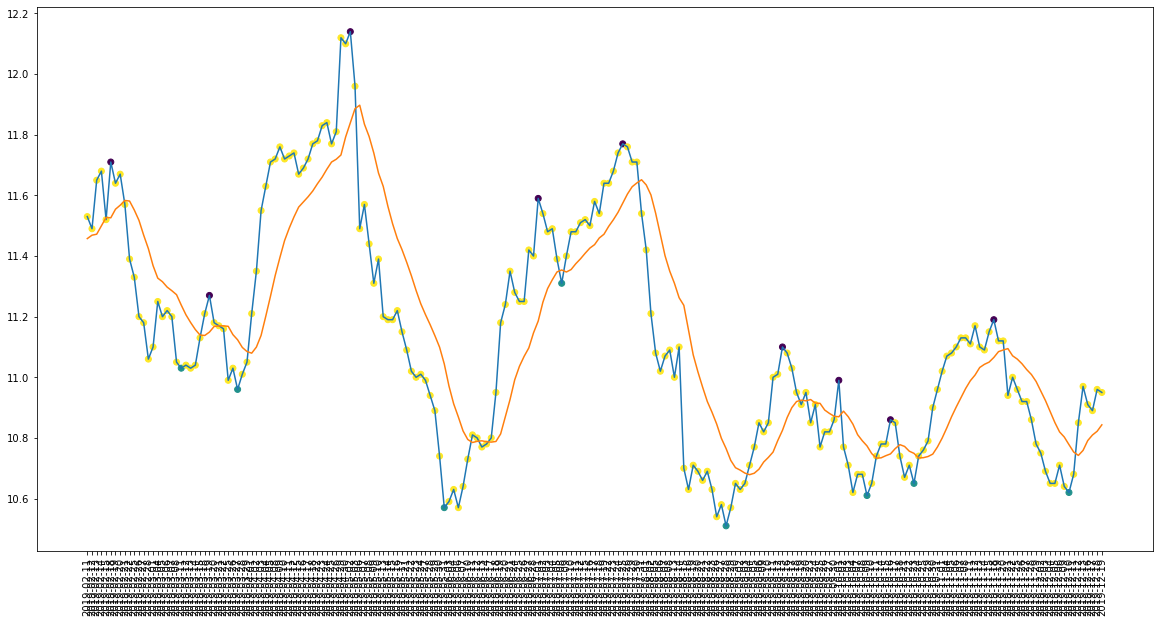

In [76]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [77]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 8
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 24
actual holds but predicted sell: 32
actual predicted holds: 145
Percentage buys correct: 0.0%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 72.13930348258707%
actual buys: 8
actual sells: 9
actual holds: 201


In [78]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.489999771118164, 11.520000457763672, 11.529999732971193, 11.56999969482422, 11.640000343322756, 11.649999618530273, 11.670000076293945, 11.68000030517578, 11.710000038146973]
[11.0600004196167, 11.100000381469727, 11.18000030517578, 11.199999809265137, 11.329999923706055, 11.390000343322756, 11.56999969482422, 11.640000343322756, 11.670000076293945]
Percentage buys correct: 37.5%
Percentage sells correct: 47.05882352941177%
Percentage holds correct: 84.90566037735849%


In [79]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $11.0600004196167
Shares owned at the moment: 901
Cash capital at the moment: $7.535705885647985


Price increase from previously bought: 5.676837362458453%
Share price: $11.720000267028807
Shares owned at the moment: 0
Cash capital at the moment: $10538.216715816972


Share price: $11.3100004196167
Shares owned at the moment: 929
Cash capital at the moment: $2.332102421041782


Stop Loss Activated!

Share price: $11.0
Shares owned at the moment: 0
Cash capital at the moment: $10193.229852421042


Share price: $10.989999771118164
Shares owned at the moment: 924
Cash capital at the moment: $10.544474489446657


Stop Loss Activated!

Share price: $10.56999969482422
Shares owned at the moment: 0
Cash capital at the moment: $9750.365823282478


Share price: $10.56999969482422
Shares owned at the moment: 919
Cash capital at the moment: $9.8230720102747


Price increase from previously bought: 7.0848988287468995%
Share price: $11.350000381469727
Shares owned at the moment: 0
Cas

In [80]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9445.467587005614
profit gained: -5.545324129943856%


### recession

In [81]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/O39.SI_data_test2.csv")
df = df.iloc[10:]
df.set_index('Date', inplace=True)
print(df.head())

            previous_1d     EMA_12   willr_14       OBV_7  labels
Date                                                             
2020-02-06        11.00  10.944147 -43.396162  18634735.0     0.0
2020-02-07        11.07  10.963509 -30.188666  22671000.0     2.0
2020-02-10        10.86  10.947584 -69.230826  16086500.0     2.0
2020-02-11        10.72  10.912571 -89.285647   9290100.0     2.0
2020-02-12        10.77  10.890637 -80.357049  13333200.0     2.0


In [82]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [83]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(215, 5, 4)

In [84]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [85]:
model = tf.keras.models.load_model("models/ocbc_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1987 - accuracy: 0.7302 - mean_squared_error: 9.1617 - weighted_accuracy: 0.7302 - weighted_mean_squared_error: 9.1617
Test loss: 0.19865624606609344
Test accuracy: 0.7302325367927551


In [86]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 169, 0: 26, 1: 20})

In [87]:
actual = [np.argmax(i, axis=None, out=None) for i in y]
Counter(actual)

Counter({2: 193, 0: 10, 1: 12})

In [88]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-12,11.02,10.890637,-80.357049,13333200.0,2.0,2,2
2020-02-13,11.05,10.910539,-32.075322,21593100.0,2.0,2,2
2020-02-14,11.06,10.931995,-15.217324,25962500.0,2.0,0,2
2020-02-17,11.01,10.951688,-13.043361,29610200.0,2.0,0,2
2020-02-18,10.97,10.960659,-23.912967,27996300.0,2.0,2,2


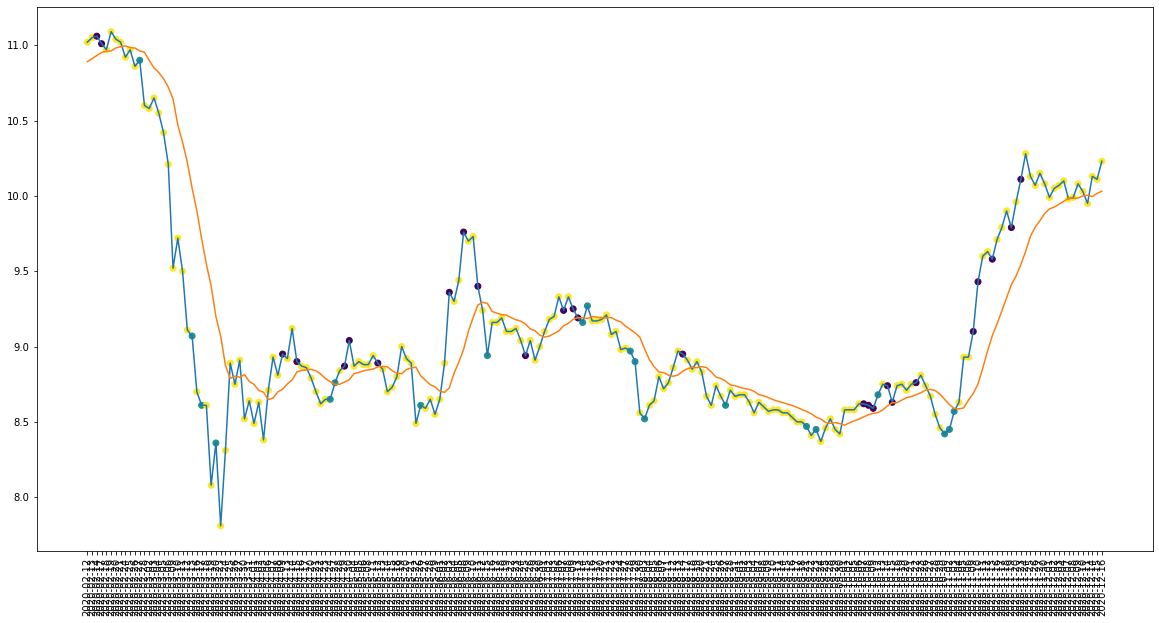

In [89]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

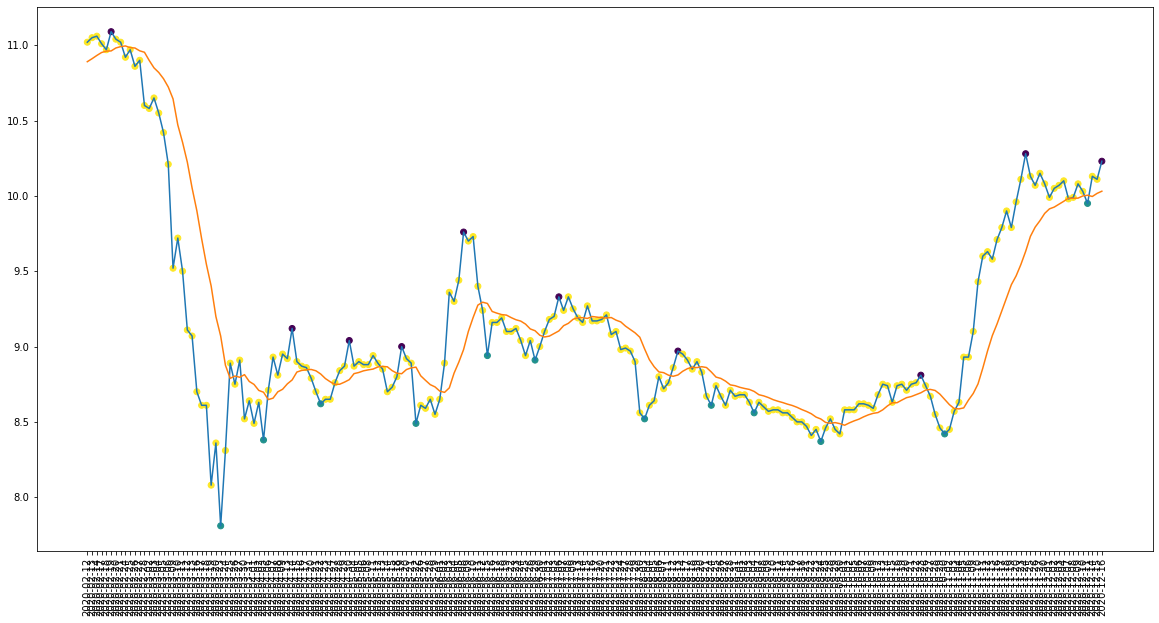

In [90]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [91]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 215
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 17
actual holds but predicted sell: 24
actual predicted holds: 152
Percentage buys correct: 25.0%
Percentage sells correct: 20.0%
Percentage holds correct: 78.75647668393782%
actual buys: 12
actual sells: 10
actual holds: 193


In [92]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[10.920000076293944, 10.970000267028807, 11.010000228881836, 11.020000457763672, 11.020000457763672, 11.039999961853027, 11.050000190734863, 11.0600004196167, 11.09000015258789]
[10.579999923706056, 10.600000381469727, 10.649999618530273, 10.859999656677246, 10.899999618530273, 10.920000076293944, 10.970000267028807, 11.020000457763672, 11.039999961853027]
Percentage buys correct: 55.0%
Percentage sells correct: 61.53846153846154%
Percentage holds correct: 86.30952380952381%


In [93]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $10.899999618530273
Shares owned at the moment: 914
Cash capital at the moment: $10.00319962215326


Stop Loss Activated!

Share price: $10.600000381469727
Shares owned at the moment: 0
Cash capital at the moment: $9671.760447326658


Share price: $9.06999969482422
Shares owned at the moment: 1063
Cash capital at the moment: $3.836895120617555


Stop Loss Activated!

Share price: $8.699999809265138
Shares owned at the moment: 0
Cash capital at the moment: $9226.504417927024


Share price: $8.609999656677246
Shares owned at the moment: 1068
Cash capital at the moment: $5.737215604063749


Stop Loss Activated!

Share price: $8.079999923706055
Shares owned at the moment: 0
Cash capital at the moment: $8611.446174346205


Share price: $8.359999656677246
Shares owned at the moment: 1027
Cash capital at the moment: $2.115797908301829


Stop Loss Activated!

Share price: $7.809999942779541
Shares owned at the moment: 0
Cash capital at the moment: $8000.928346804495


Share price:

In [94]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $9233.011672363282
profit gained: -7.669883276367181%


## CNOOC Limited

In [95]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data.csv")
print(df.head())

         Date  previous_1d    EMA_12   willr_14       OBV_7  labels
0  2004-04-07        3.250  3.264699 -57.142857  31539206.0     2.0
1  2004-04-08        3.200  3.254745 -78.947368 -24878594.0     2.0
2  2004-04-13        3.250  3.254015 -52.631579  10937473.0     0.0
3  2004-04-14        3.375  3.272628 -10.416706  98972973.0     2.0
4  2004-04-15        3.275  3.272993 -52.083331  47190715.0     2.0


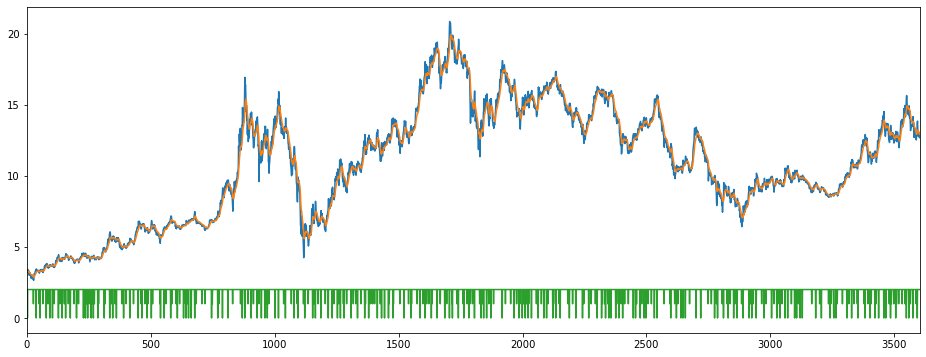

In [96]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [97]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2004-04-07,3.250,3.264699,-57.142857,31539206.0,2.0
2004-04-08,3.200,3.254745,-78.947368,-24878594.0,2.0
2004-04-13,3.250,3.254015,-52.631579,10937473.0,0.0
2004-04-14,3.375,3.272628,-10.416706,98972973.0,2.0
2004-04-15,3.275,3.272993,-52.083331,47190715.0,2.0


In [98]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1

In [99]:
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
X.shape

(3600, 5, 4)

In [100]:
y = labels
y = np.array(y)

In [101]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [102]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [103]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [104]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [105]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[1 2 2 ... 2 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
23/23 [==============================] - 1s 36ms/step - loss: 0.2881 - accuracy: 0.4507 - mse: 0.4343 - weighted_accuracy: 0.3373 - weighted_mse: 0.4708 - val_loss: 0.3021 - val_accuracy: 0.0444 - val_mse: 0.3425 - val_weighted_accuracy: 0.0444 - val_weighted_mse: 0.3425
Epoch 2/200
23/23 [==============================] - 0s 6ms/step - loss: 0.2150 - accuracy: 0.3267 - mse: 0.6649 - weighted_accuracy: 0.4923 - weighted_mse: 0.6364 - val_loss: 0.2965 - val_accuracy: 0.0444 - val_mse: 0.3573 - val_weighted_accuracy: 0.0444 - val_weighted_mse: 0.3573
Epoch 3/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1883 - accuracy: 0.2653 - mse: 0.8887 - weighted_accuracy: 0.5594 - weighted_mse: 0.8432 - val_loss: 0.2889 - val_accuracy: 0.0444 - val_mse: 0.3769 - val_weighted_accuracy: 0.0444 - val_weighted_mse: 0.3769
Epoch 4/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1760 - accuracy: 0.2292 - mse: 1.0882 - weighted_accuracy: 0.5824 - weighte

Epoch 30/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1330 - accuracy: 0.4233 - mse: 1.6658 - weighted_accuracy: 0.7163 - weighted_mse: 1.6232 - val_loss: 0.1865 - val_accuracy: 0.3625 - val_mse: 1.4560 - val_weighted_accuracy: 0.3625 - val_weighted_mse: 1.4560
Epoch 31/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1327 - accuracy: 0.3962 - mse: 1.7000 - weighted_accuracy: 0.7062 - weighted_mse: 1.6417 - val_loss: 0.1844 - val_accuracy: 0.3736 - val_mse: 1.4721 - val_weighted_accuracy: 0.3736 - val_weighted_mse: 1.4721
Epoch 32/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1309 - accuracy: 0.4222 - mse: 1.7064 - weighted_accuracy: 0.7206 - weighted_mse: 1.6591 - val_loss: 0.1801 - val_accuracy: 0.4056 - val_mse: 1.4939 - val_weighted_accuracy: 0.4056 - val_weighted_mse: 1.4939
Epoch 33/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1312 - accuracy: 0.4319 - mse: 1.7105 - weighted_accuracy: 0.7169 - weig

Epoch 59/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1089 - accuracy: 0.5872 - mse: 2.0539 - weighted_accuracy: 0.8101 - weighted_mse: 2.0970 - val_loss: 0.1730 - val_accuracy: 0.5236 - val_mse: 2.1226 - val_weighted_accuracy: 0.5236 - val_weighted_mse: 2.1226
Epoch 60/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1093 - accuracy: 0.5656 - mse: 2.0988 - weighted_accuracy: 0.8046 - weighted_mse: 2.1347 - val_loss: 0.1584 - val_accuracy: 0.5806 - val_mse: 2.2279 - val_weighted_accuracy: 0.5806 - val_weighted_mse: 2.2279
Epoch 61/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1078 - accuracy: 0.5941 - mse: 2.0910 - weighted_accuracy: 0.8150 - weighted_mse: 2.1298 - val_loss: 0.1823 - val_accuracy: 0.5083 - val_mse: 2.2392 - val_weighted_accuracy: 0.5083 - val_weighted_mse: 2.2392
Epoch 62/200
23/23 [==============================] - 0s 6ms/step - loss: 0.1064 - accuracy: 0.5486 - mse: 2.1364 - weighted_accuracy: 0.7863 - weig

Epoch 88/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0890 - accuracy: 0.6597 - mse: 2.7605 - weighted_accuracy: 0.8535 - weighted_mse: 2.8930 - val_loss: 0.1473 - val_accuracy: 0.6667 - val_mse: 2.7885 - val_weighted_accuracy: 0.6667 - val_weighted_mse: 2.7885
Epoch 89/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0875 - accuracy: 0.6830 - mse: 2.7247 - weighted_accuracy: 0.8669 - weighted_mse: 2.8710 - val_loss: 0.1744 - val_accuracy: 0.5708 - val_mse: 2.8709 - val_weighted_accuracy: 0.5708 - val_weighted_mse: 2.8709
Epoch 90/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0887 - accuracy: 0.6819 - mse: 2.7452 - weighted_accuracy: 0.8689 - weighted_mse: 2.8538 - val_loss: 0.1590 - val_accuracy: 0.6153 - val_mse: 2.9920 - val_weighted_accuracy: 0.6153 - val_weighted_mse: 2.9920
Epoch 91/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0865 - accuracy: 0.6760 - mse: 2.7905 - weighted_accuracy: 0.8667 - weig

Epoch 117/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0729 - accuracy: 0.7458 - mse: 3.6570 - weighted_accuracy: 0.8971 - weighted_mse: 3.8635 - val_loss: 0.1628 - val_accuracy: 0.6778 - val_mse: 3.7439 - val_weighted_accuracy: 0.6778 - val_weighted_mse: 3.7439
Epoch 118/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0716 - accuracy: 0.7705 - mse: 3.6335 - weighted_accuracy: 0.9013 - weighted_mse: 3.8233 - val_loss: 0.1792 - val_accuracy: 0.6014 - val_mse: 3.9259 - val_weighted_accuracy: 0.6014 - val_weighted_mse: 3.9259
Epoch 119/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0698 - accuracy: 0.7670 - mse: 3.6320 - weighted_accuracy: 0.9097 - weighted_mse: 3.8122 - val_loss: 0.1435 - val_accuracy: 0.7278 - val_mse: 3.8257 - val_weighted_accuracy: 0.7278 - val_weighted_mse: 3.8257
Epoch 120/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0683 - accuracy: 0.7840 - mse: 3.6261 - weighted_accuracy: 0.9184 - 

Epoch 146/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0572 - accuracy: 0.8264 - mse: 4.6770 - weighted_accuracy: 0.9339 - weighted_mse: 4.8817 - val_loss: 0.1834 - val_accuracy: 0.6528 - val_mse: 4.7844 - val_weighted_accuracy: 0.6528 - val_weighted_mse: 4.7844
Epoch 147/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0555 - accuracy: 0.8403 - mse: 4.6925 - weighted_accuracy: 0.9294 - weighted_mse: 4.8441 - val_loss: 0.1987 - val_accuracy: 0.6458 - val_mse: 5.2081 - val_weighted_accuracy: 0.6458 - val_weighted_mse: 5.2081
Epoch 148/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0559 - accuracy: 0.8319 - mse: 4.7582 - weighted_accuracy: 0.9263 - weighted_mse: 4.9010 - val_loss: 0.1882 - val_accuracy: 0.6667 - val_mse: 5.2858 - val_weighted_accuracy: 0.6667 - val_weighted_mse: 5.2858
Epoch 149/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0576 - accuracy: 0.8177 - mse: 4.7791 - weighted_accuracy: 0.9283 - 

Epoch 175/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0444 - accuracy: 0.8823 - mse: 6.0288 - weighted_accuracy: 0.9472 - weighted_mse: 5.9817 - val_loss: 0.1788 - val_accuracy: 0.7458 - val_mse: 7.0998 - val_weighted_accuracy: 0.7458 - val_weighted_mse: 7.0998
Epoch 176/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0445 - accuracy: 0.8681 - mse: 6.0979 - weighted_accuracy: 0.9516 - weighted_mse: 6.0891 - val_loss: 0.1932 - val_accuracy: 0.7028 - val_mse: 6.4023 - val_weighted_accuracy: 0.7028 - val_weighted_mse: 6.4023
Epoch 177/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0470 - accuracy: 0.8535 - mse: 6.1527 - weighted_accuracy: 0.9414 - weighted_mse: 6.1922 - val_loss: 0.1707 - val_accuracy: 0.7472 - val_mse: 6.6017 - val_weighted_accuracy: 0.7472 - val_weighted_mse: 6.6017
Epoch 178/200
23/23 [==============================] - 0s 6ms/step - loss: 0.0447 - accuracy: 0.8722 - mse: 6.1373 - weighted_accuracy: 0.9434 - 

In [106]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18470098078250885
Test accuracy: 0.7972221970558167


In [107]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-3.9040198   0.01032466 -0.13788632]
 [-4.2225857  -0.6903314   0.20906983]
 [-1.0214913  -2.0566285  -0.62258804]
 ...
 [-3.0712128  -1.1315192   0.9425384 ]
 [-3.8625922  -0.77479523  0.30306697]
 [-0.82026505 -4.485859   -0.43250564]]


Counter({1: 67, 2: 615, 0: 38})

In [108]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 655, 0: 33, 1: 32})

In [109]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 720
actual predicted buys: 9
actual buys but predicted sell: 0
actual buys but predicted hold: 23
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 30
actual holds but predicted buy: 58
actual holds but predicted sell: 35
actual predicted holds: 562
Percentage buys correct: 28.125%
Percentage sells correct: 9.090909090909092%
Percentage holds correct: 85.80152671755725%
actual buys: 32
actual sells: 33
actual holds: 655


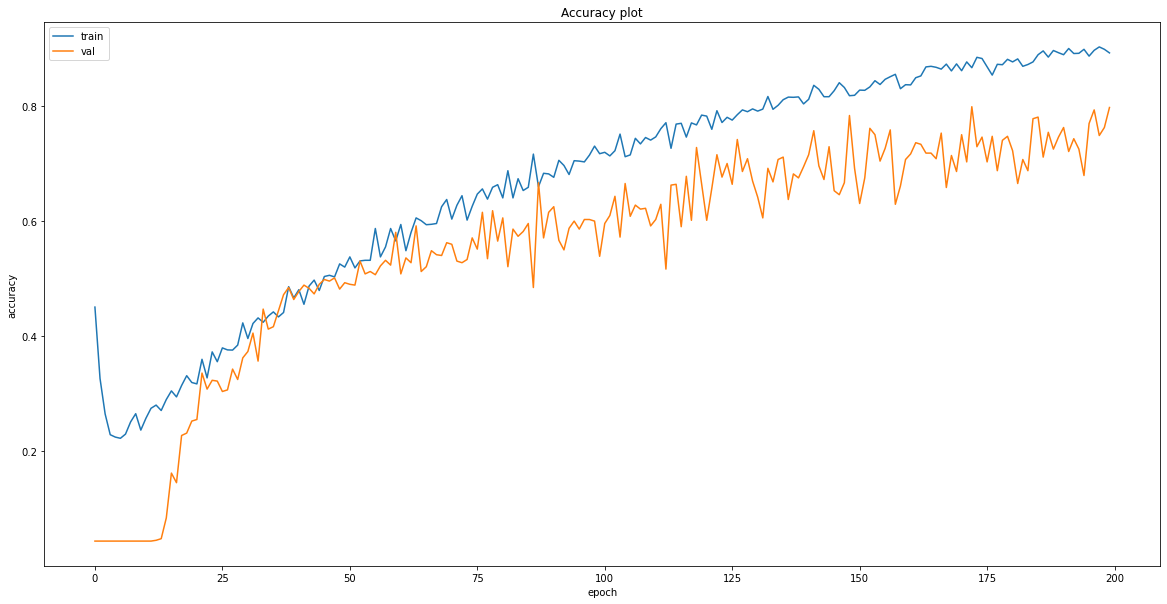

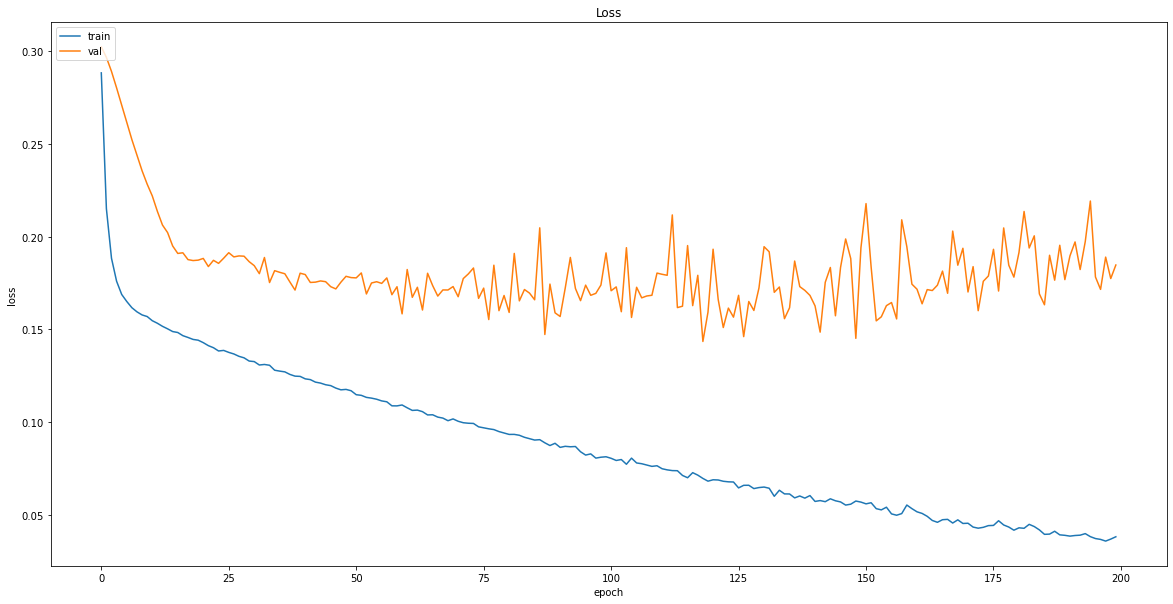

In [110]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [111]:
# Save model
model.save("models/{}".format('cnooc_time_series_lstm_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/cnooc_time_series_lstm_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [112]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-02-08,13.20,12.920431,-9.302320,507661024.0,2.0
2019-02-11,12.88,12.914211,-46.511602,447901134.0,2.0
2019-02-12,12.90,12.912024,-54.285745,495941238.0,2.0
2019-02-13,13.08,12.937867,-28.571409,545190223.0,2.0
2019-02-14,13.38,13.005887,-9.090899,594167146.0,2.0


In [113]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(211, 5, 4)

In [114]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [115]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1622 - accuracy: 0.8246 - mean_squared_error: 7.8271 - weighted_accuracy: 0.8246 - weighted_mean_squared_error: 7.8271
Test loss: 0.16219931840896606
Test accuracy: 0.8246445655822754


In [116]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 185, 0: 11, 1: 15})

In [117]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [118]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-14,13.46,13.005887,-9.090899,594167146.0,2.0,2,2
2019-02-15,13.28,13.075751,-2.222168,636062191.0,2.0,2,2
2019-02-18,13.68,13.107174,-22.222210,601994876.0,2.0,2,2
2019-02-19,13.76,13.195301,-15.384598,654106730.0,2.0,2,2
2019-02-20,13.92,13.282178,-9.230759,687559434.0,2.0,2,2


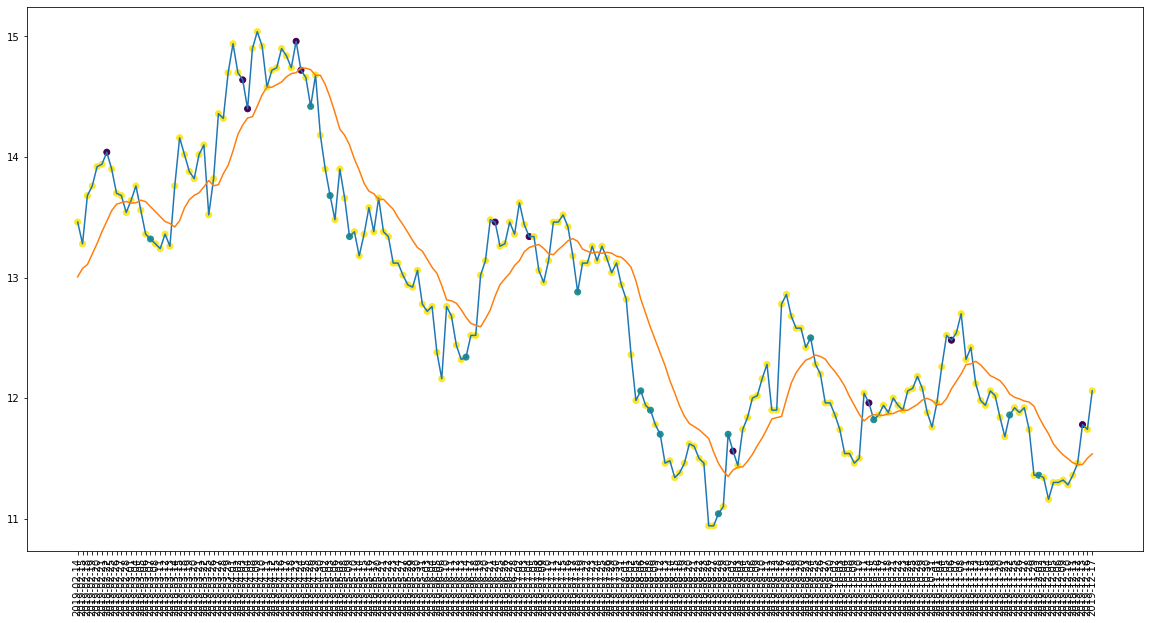

In [119]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

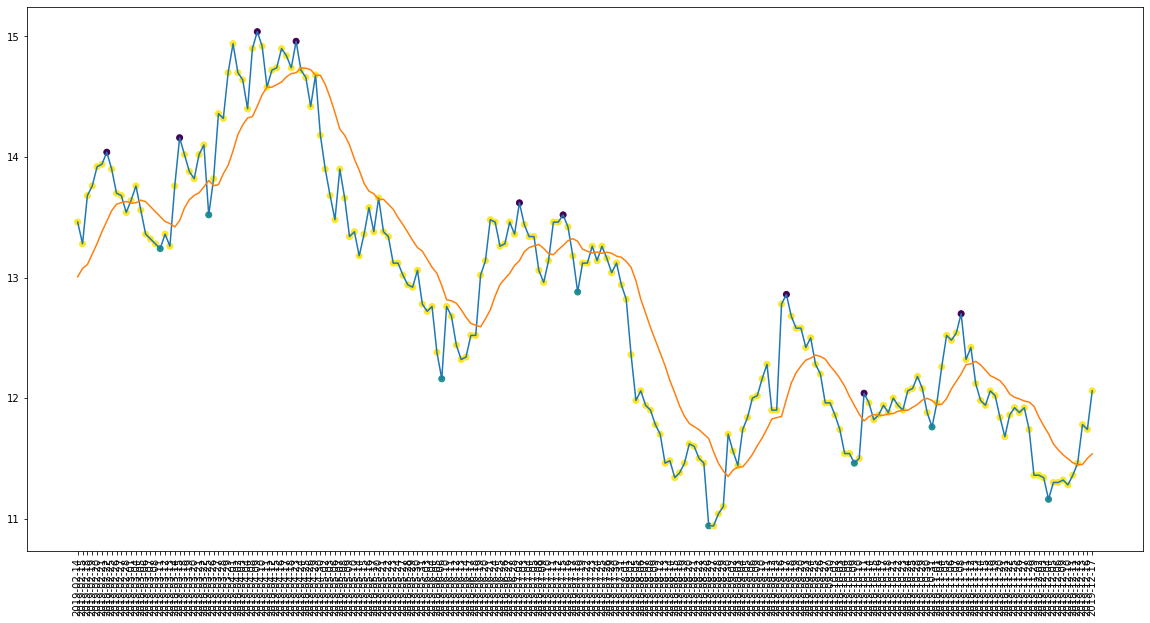

In [120]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [121]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 211
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 7
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 7
actual holds but predicted buy: 14
actual holds but predicted sell: 9
actual predicted holds: 171
Percentage buys correct: 12.5%
Percentage sells correct: 22.22222222222222%
Percentage holds correct: 88.14432989690722%
actual buys: 8
actual sells: 9
actual holds: 194


In [122]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[13.279999732971193, 13.460000038146973, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 13.920000076293945, 13.9399995803833, 14.039999961853027]
[13.359999656677244, 13.539999961853027, 13.5600004196167, 13.640000343322756, 13.68000030517578, 13.699999809265135, 13.760000228881836, 13.899999618530273, 14.039999961853027]
Percentage buys correct: 60.0%
Percentage sells correct: 54.54545454545455%
Percentage holds correct: 82.06521739130434%


In [123]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $13.31999969482422
Shares owned at the moment: 748
Cash capital at the moment: $9.240988899229706


Price increase from previously bought: 9.608491653517358%
Share price: $14.640000343322756
Shares owned at the moment: 0
Cash capital at the moment: $10929.846764998436


Share price: $14.420000076293945
Shares owned at the moment: 755
Cash capital at the moment: $12.807182238100722


Stop Loss Activated!

Share price: $13.899999618530273
Shares owned at the moment: 0
Cash capital at the moment: $10478.447020020483


Share price: $13.68000030517578
Shares owned at the moment: 763
Cash capital at the moment: $11.902726531028748


Stop Loss Activated!

Share price: $13.18000030517578
Shares owned at the moment: 0
Cash capital at the moment: $10040.588023739812


Share price: $12.34000015258789
Shares owned at the moment: 811
Cash capital at the moment: $5.326614650723059


Price increase from previously bought: 8.777037148731903%
Share price: $13.460000038146973
Shares owned a

In [124]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8912.067081356048
profit gained: -10.879329186439518%


### Recession

In [125]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/0883.HK_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-02-07,12.60,12.453556,-47.619039,117731211.0,2.0
2020-02-10,12.26,12.423778,-63.809519,69675784.0,2.0
2020-02-11,12.18,12.386274,-67.619039,33507859.0,2.0
2020-02-12,12.32,12.376078,-56.842113,67402284.0,2.0
2020-02-13,12.44,12.385912,-50.526328,113135355.0,2.0


In [126]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(213, 5, 4)

In [127]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [128]:
model = tf.keras.models.load_model("models/cnooc_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1961 - accuracy: 0.7700 - mean_squared_error: 8.7604 - weighted_accuracy: 0.7700 - weighted_mean_squared_error: 8.7604
Test loss: 0.1960877925157547
Test accuracy: 0.7699530720710754


In [129]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 173, 1: 31, 0: 9})

In [130]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [131]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-13,12.34,12.385912,-50.526328,113135355.0,2.0,2,2
2020-02-14,12.34,12.378849,-50.588221,60757697.0,2.0,2,2
2020-02-17,12.26,12.372872,-46.153851,60757697.0,2.0,2,2
2020-02-18,12.00,12.355507,-38.709648,5146960.0,2.0,2,2
2020-02-19,12.08,12.300814,-59.677412,-52626865.0,2.0,2,2


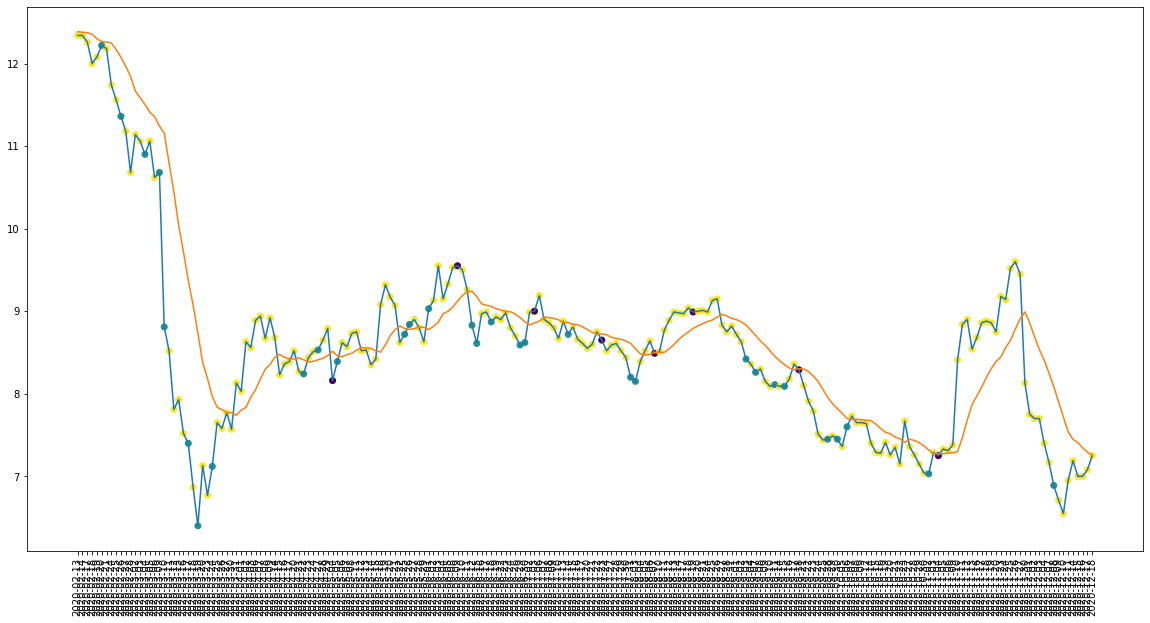

In [132]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

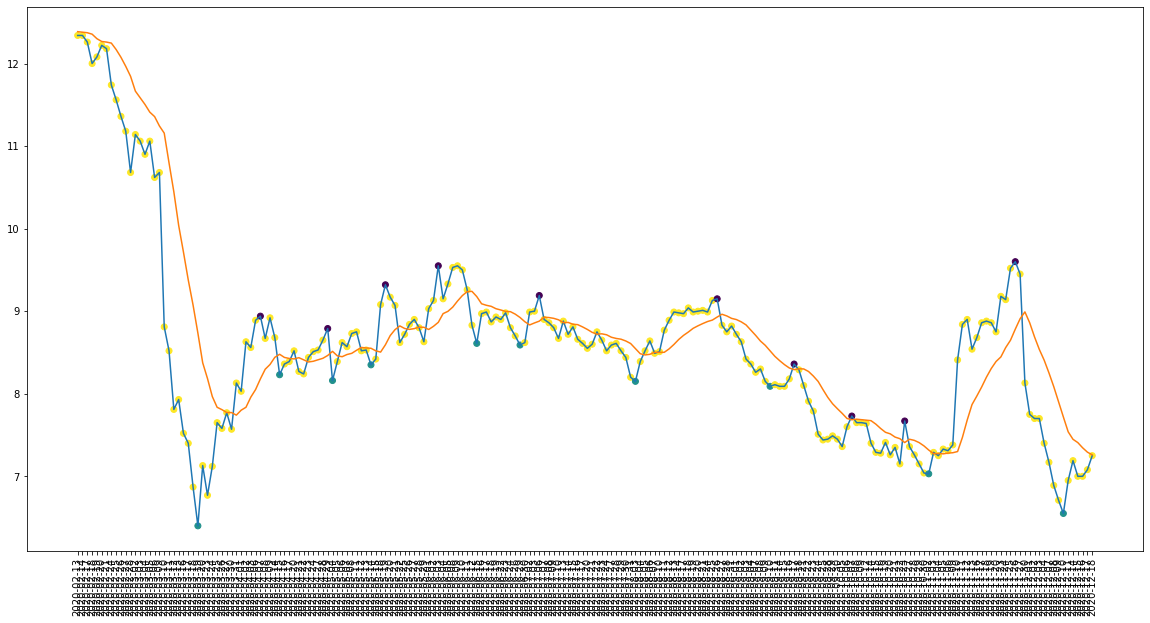

In [133]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [134]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 213
actual predicted buys: 5
actual buys but predicted sell: 1
actual buys but predicted hold: 4
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 10
actual holds but predicted buy: 26
actual holds but predicted sell: 8
actual predicted holds: 159
Percentage buys correct: 50.0%
Percentage sells correct: 0.0%
Percentage holds correct: 82.38341968911917%
actual buys: 10
actual sells: 10
actual holds: 193


In [135]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[11.5600004196167, 11.739999771118164, 12.0, 12.079999923706055, 12.18000030517578, 12.220000267028807, 12.260000228881836, 12.34000015258789, 12.34000015258789]
[10.68000030517578, 10.899999618530273, 11.0600004196167, 11.140000343322754, 11.18000030517578, 11.359999656677244, 11.5600004196167, 11.739999771118164, 12.18000030517578]
Percentage buys correct: 61.29032258064516%
Percentage sells correct: 50.0%
Percentage holds correct: 83.81502890173411%


In [136]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $12.220000267028807
Shares owned at the moment: 816
Cash capital at the moment: $1.058101505281229


Stop Loss Activated!

Share price: $11.739999771118164
Shares owned at the moment: 0
Cash capital at the moment: $9554.553355251313


Share price: $11.359999656677244
Shares owned at the moment: 838
Cash capital at the moment: $8.694523746969935


Stop Loss Activated!

Share price: $10.68000030517578
Shares owned at the moment: 0
Cash capital at the moment: $8933.922718780996


Share price: $10.899999618530273
Shares owned at the moment: 817
Cash capital at the moment: $4.133456298828605


Stop Loss Activated!

Share price: $8.8100004196167
Shares owned at the moment: 0
Cash capital at the moment: $7182.109930682898


Share price: $8.8100004196167
Shares owned at the moment: 812
Cash capital at the moment: $8.716859017134084


Stop Loss Activated!

Share price: $8.520000457763674
Shares owned at the moment: 0
Cash capital at the moment: $6907.932069699051


Share price: $7.

In [137]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $5843.750896369933
profit gained: -41.56249103630067%


## JP Morgan

In [138]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14       OBV_7  labels
0  2000-01-21    49.375000  48.388499 -42.592593  -2894250.0     2.0
1  2000-01-24    48.625000  48.424884 -39.516144  -8054850.0     2.0
2  2000-01-25    48.666668  48.462081 -38.709668  -1595700.0     2.0
3  2000-01-26    49.750000  48.660222 -17.741956   5984250.0     2.0
4  2000-01-27    52.291668  49.218906  -5.232557  14370900.0     2.0


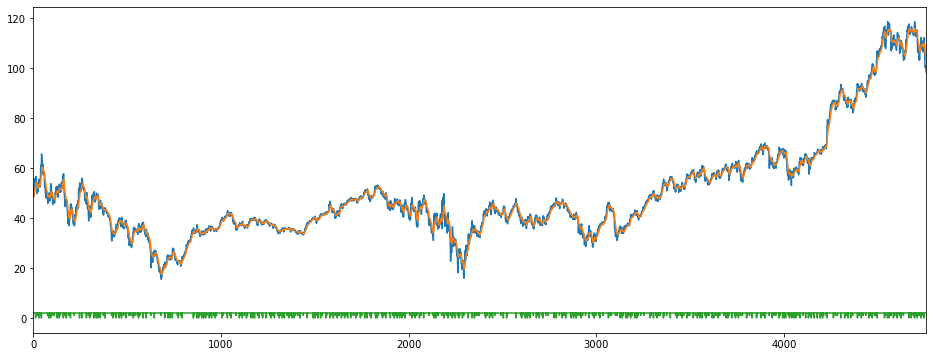

In [139]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [140]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,49.375000,48.388499,-42.592593,-2894250.0,2.0
2000-01-24,48.625000,48.424884,-39.516144,-8054850.0,2.0
2000-01-25,48.666668,48.462081,-38.709668,-1595700.0,2.0
2000-01-26,49.750000,48.660222,-17.741956,5984250.0,2.0
2000-01-27,52.291668,49.218906,-5.232557,14370900.0,2.0


In [141]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(4755, 5, 4)

In [142]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [143]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [144]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [145]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [146]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 0 2 2] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 29ms/step - loss: 0.2667 - accuracy: 0.4585 - mse: 0.4599 - weighted_accuracy: 0.4061 - weighted_mse: 0.4878 - val_loss: 0.3004 - val_accuracy: 0.0452 - val_mse: 0.3468 - val_weighted_accuracy: 0.0452 - val_weighted_mse: 0.3468
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1976 - accuracy: 0.2923 - mse: 0.8056 - weighted_accuracy: 0.5536 - weighted_mse: 0.7423 - val_loss: 0.2910 - val_accuracy: 0.0452 - val_mse: 0.3679 - val_weighted_accuracy: 0.0452 - val_weighted_mse: 0.3679
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1757 - accuracy: 0.2468 - mse: 1.0881 - weighted_accuracy: 0.5762 - weighted_mse: 1.0033 - val_loss: 0.2790 - val_accuracy: 0.0452 - val_mse: 0.3944 - val_weighted_accuracy: 0.0452 - val_weighted_mse: 0.3944
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1667 - accuracy: 0.2542 - mse: 1.2776 - weighted_accuracy: 0.5906 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1313 - accuracy: 0.4006 - mse: 1.8723 - weighted_accuracy: 0.7299 - weighted_mse: 1.7937 - val_loss: 0.1870 - val_accuracy: 0.3659 - val_mse: 1.7337 - val_weighted_accuracy: 0.3659 - val_weighted_mse: 1.7337
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1293 - accuracy: 0.4427 - mse: 1.8623 - weighted_accuracy: 0.7395 - weighted_mse: 1.7982 - val_loss: 0.1850 - val_accuracy: 0.3954 - val_mse: 1.7972 - val_weighted_accuracy: 0.3954 - val_weighted_mse: 1.7972
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1282 - accuracy: 0.4658 - mse: 1.8651 - weighted_accuracy: 0.7498 - weighted_mse: 1.8130 - val_loss: 0.1898 - val_accuracy: 0.3722 - val_mse: 1.7459 - val_weighted_accuracy: 0.3722 - val_weighted_mse: 1.7459
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1278 - accuracy: 0.4387 - mse: 1.8977 - weighted_accuracy: 0.7455 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1054 - accuracy: 0.6254 - mse: 2.2375 - weighted_accuracy: 0.8345 - weighted_mse: 2.2099 - val_loss: 0.1933 - val_accuracy: 0.4427 - val_mse: 2.4371 - val_weighted_accuracy: 0.4427 - val_weighted_mse: 2.4371
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1041 - accuracy: 0.5886 - mse: 2.3586 - weighted_accuracy: 0.8137 - weighted_mse: 2.3254 - val_loss: 0.1613 - val_accuracy: 0.5542 - val_mse: 2.4025 - val_weighted_accuracy: 0.5542 - val_weighted_mse: 2.4025
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1043 - accuracy: 0.5975 - mse: 2.3689 - weighted_accuracy: 0.8246 - weighted_mse: 2.3408 - val_loss: 0.1779 - val_accuracy: 0.5068 - val_mse: 2.4304 - val_weighted_accuracy: 0.5068 - val_weighted_mse: 2.4304
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1048 - accuracy: 0.6007 - mse: 2.3358 - weighted_accuracy: 0.8256 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0860 - accuracy: 0.7008 - mse: 3.0625 - weighted_accuracy: 0.8678 - weighted_mse: 3.0577 - val_loss: 0.1860 - val_accuracy: 0.5342 - val_mse: 3.4633 - val_weighted_accuracy: 0.5342 - val_weighted_mse: 3.4633
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0828 - accuracy: 0.6982 - mse: 3.0813 - weighted_accuracy: 0.8726 - weighted_mse: 3.0779 - val_loss: 0.1625 - val_accuracy: 0.6162 - val_mse: 3.0832 - val_weighted_accuracy: 0.6162 - val_weighted_mse: 3.0832
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0832 - accuracy: 0.7234 - mse: 3.1692 - weighted_accuracy: 0.8855 - weighted_mse: 3.1385 - val_loss: 0.1863 - val_accuracy: 0.5373 - val_mse: 3.2842 - val_weighted_accuracy: 0.5373 - val_weighted_mse: 3.2842
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0827 - accuracy: 0.7093 - mse: 3.1581 - weighted_accuracy: 0.8822 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0691 - accuracy: 0.7616 - mse: 4.0812 - weighted_accuracy: 0.9013 - weighted_mse: 3.9888 - val_loss: 0.2030 - val_accuracy: 0.5626 - val_mse: 4.0888 - val_weighted_accuracy: 0.5626 - val_weighted_mse: 4.0888
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0647 - accuracy: 0.7936 - mse: 4.1549 - weighted_accuracy: 0.9188 - weighted_mse: 4.0748 - val_loss: 0.1809 - val_accuracy: 0.6099 - val_mse: 4.3173 - val_weighted_accuracy: 0.6099 - val_weighted_mse: 4.3173
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0659 - accuracy: 0.7779 - mse: 4.2154 - weighted_accuracy: 0.9112 - weighted_mse: 4.1281 - val_loss: 0.1529 - val_accuracy: 0.7182 - val_mse: 4.5552 - val_weighted_accuracy: 0.7182 - val_weighted_mse: 4.5552
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0645 - accuracy: 0.7955 - mse: 4.3091 - weighted_accuracy: 0.9175 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0526 - accuracy: 0.8381 - mse: 5.6040 - weighted_accuracy: 0.9369 - weighted_mse: 5.3094 - val_loss: 0.1723 - val_accuracy: 0.7098 - val_mse: 5.4085 - val_weighted_accuracy: 0.7098 - val_weighted_mse: 5.4085
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0520 - accuracy: 0.8473 - mse: 5.5385 - weighted_accuracy: 0.9403 - weighted_mse: 5.2133 - val_loss: 0.1914 - val_accuracy: 0.6730 - val_mse: 5.5972 - val_weighted_accuracy: 0.6730 - val_weighted_mse: 5.5972
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0513 - accuracy: 0.8452 - mse: 5.5854 - weighted_accuracy: 0.9415 - weighted_mse: 5.2563 - val_loss: 0.2005 - val_accuracy: 0.6404 - val_mse: 6.0391 - val_weighted_accuracy: 0.6404 - val_weighted_mse: 6.0391
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0533 - accuracy: 0.8354 - mse: 5.7930 - weighted_accuracy: 0.9304 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0431 - accuracy: 0.8775 - mse: 7.2740 - weighted_accuracy: 0.9534 - weighted_mse: 6.6577 - val_loss: 0.2021 - val_accuracy: 0.7277 - val_mse: 7.0490 - val_weighted_accuracy: 0.7277 - val_weighted_mse: 7.0490
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0428 - accuracy: 0.8767 - mse: 7.1549 - weighted_accuracy: 0.9492 - weighted_mse: 6.5451 - val_loss: 0.1776 - val_accuracy: 0.7729 - val_mse: 7.5098 - val_weighted_accuracy: 0.7729 - val_weighted_mse: 7.5098
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0394 - accuracy: 0.8959 - mse: 7.2657 - weighted_accuracy: 0.9619 - weighted_mse: 6.5438 - val_loss: 0.2034 - val_accuracy: 0.7298 - val_mse: 8.0640 - val_weighted_accuracy: 0.7298 - val_weighted_mse: 8.0640
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0416 - accuracy: 0.8767 - mse: 7.4571 - weighted_accuracy: 0.9512 - 

In [147]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.18745774030685425
Test accuracy: 0.8212407827377319


In [148]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-0.93229276 -6.135375    0.32599655]
 [-2.507036   -6.2461643   1.6280206 ]
 [-1.6087041  -6.4458847   0.865021  ]
 ...
 [-4.390106   -2.4315133   1.5827241 ]
 [-1.1954978  -5.5838265   0.88504624]
 [-4.4182425  -4.6856146   3.0057402 ]]


Counter({2: 849, 1: 55, 0: 47})

In [149]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 867, 0: 41, 1: 43})

In [150]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 951
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 38
actual sells but predicted buy: 0
actual predicted sells: 3
actual sells but predicted hold: 38
actual holds but predicted buy: 50
actual holds but predicted sell: 44
actual predicted holds: 773
Percentage buys correct: 11.627906976744185%
Percentage sells correct: 7.317073170731708%
Percentage holds correct: 89.15801614763552%
actual buys: 43
actual sells: 41
actual holds: 867


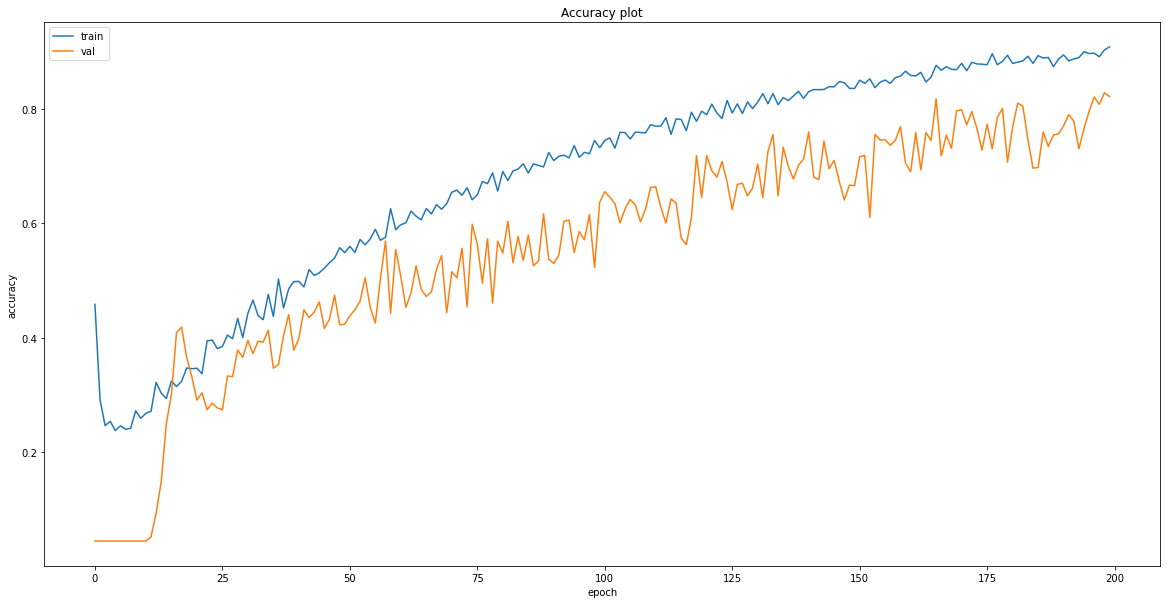

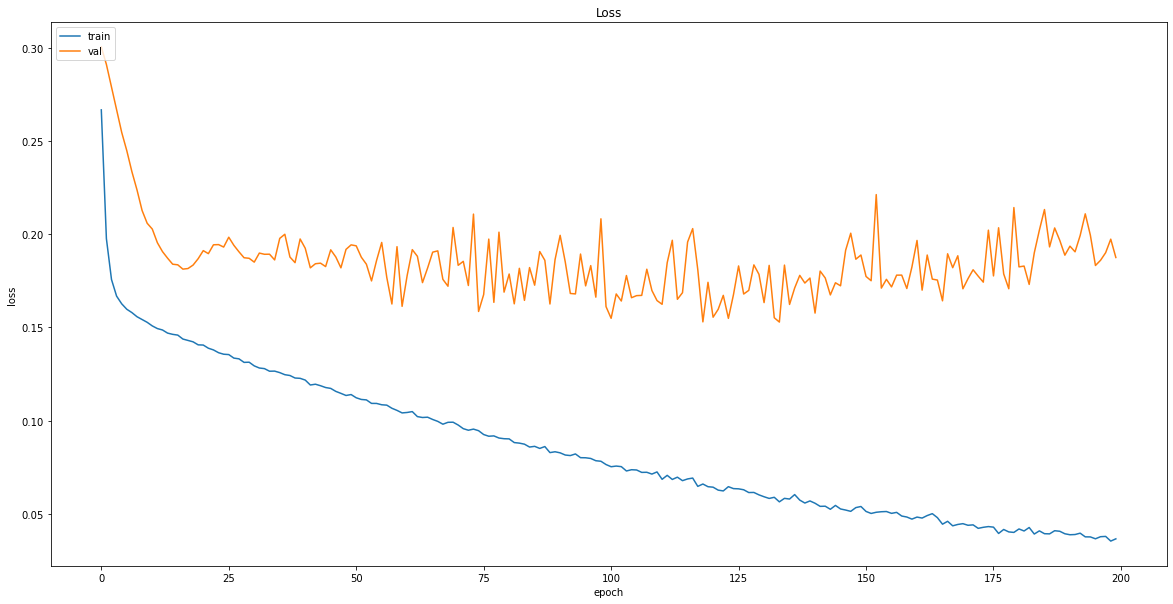

In [151]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [152]:
# Save model
model.save("models/{}".format('jpm_time_series_lstm_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/jpm_time_series_lstm_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [153]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-02-05,104.250000,103.300007,-14.909608,120675400.0,2.0
2019-02-06,103.790001,103.375391,-42.151138,107912400.0,2.0
2019-02-07,103.739998,103.431484,-45.180727,99167400.0,2.0
2019-02-08,102.379997,103.269717,-75.263265,85989900.0,2.0
2019-02-11,101.360001,102.975915,-74.903417,73097300.0,1.0


In [154]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(218, 5, 4)

In [155]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [156]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.1843 - accuracy: 0.8349 - mean_squared_error: 10.0879 - weighted_accuracy: 0.8349 - weighted_mean_squared_error: 10.0879
Test loss: 0.184279665350914
Test accuracy: 0.8348624110221863


In [157]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 199, 1: 10, 0: 9})

In [158]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [159]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,100.879997,102.975915,-74.903417,73097300.0,1.0,2,1
2019-02-12,102.599998,102.653466,-84.169891,62118800.0,2.0,1,2
2019-02-13,103.089996,102.645240,-50.965236,74971100.0,2.0,2,2
2019-02-14,102.419998,102.713664,-41.505819,85725200.0,2.0,2,2
2019-02-15,105.550003,102.668485,-54.440145,74206700.0,2.0,2,2


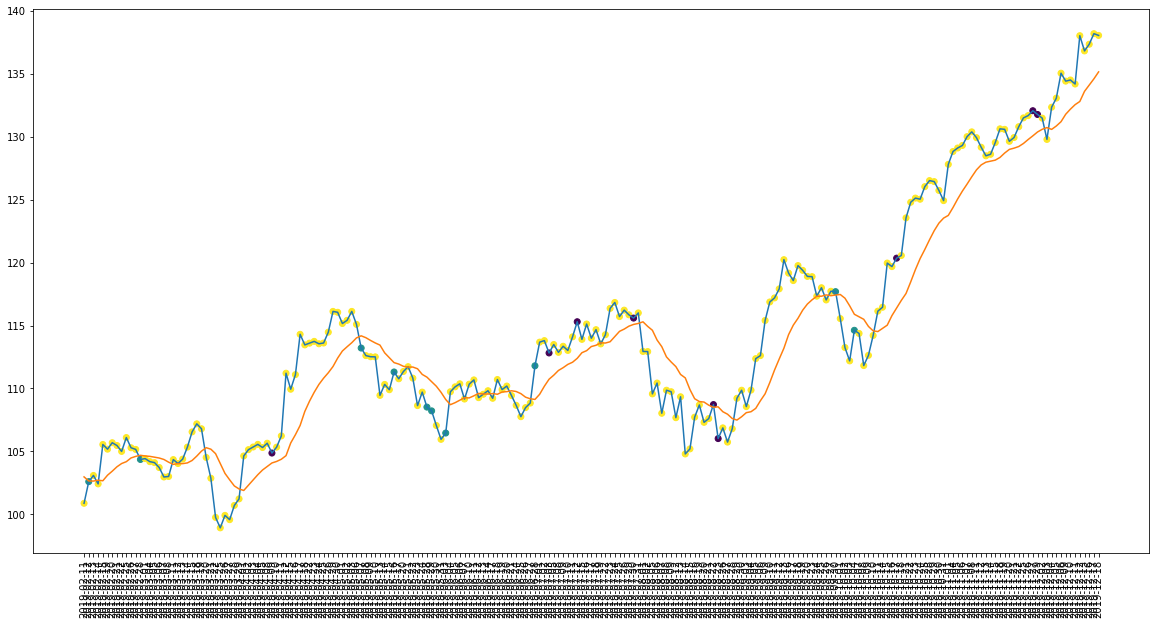

In [160]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

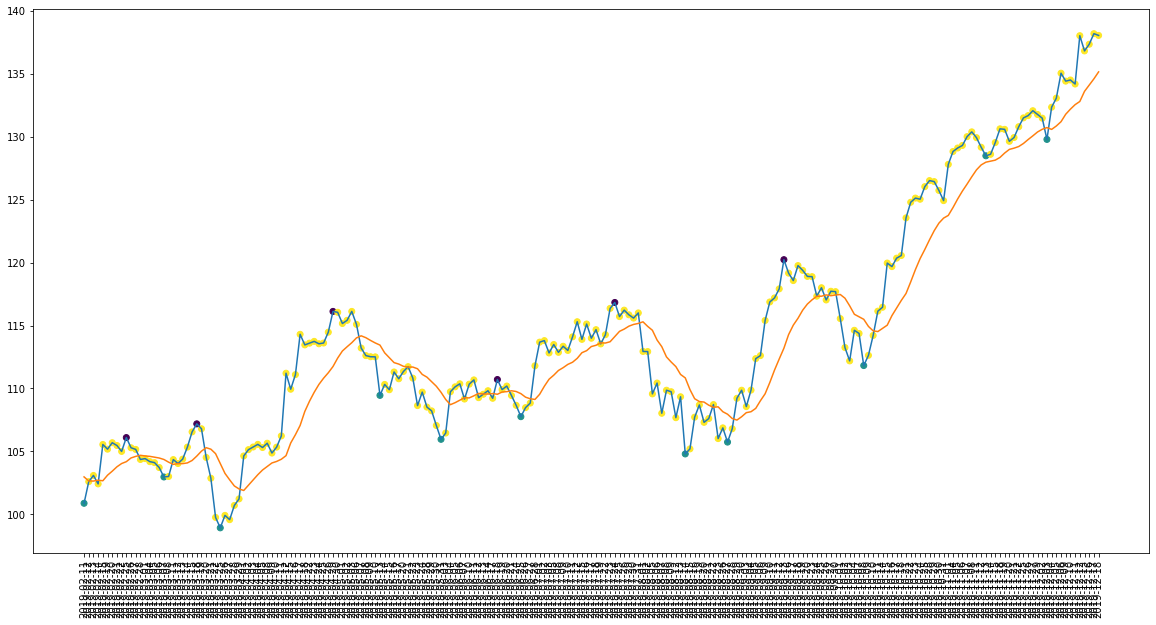

In [161]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [162]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 0
actual buys but predicted sell: 0
actual buys but predicted hold: 11
actual sells but predicted buy: 0
actual predicted sells: 0
actual sells but predicted hold: 6
actual holds but predicted buy: 10
actual holds but predicted sell: 9
actual predicted holds: 182
Percentage buys correct: 0.0%
Percentage sells correct: 0.0%
Percentage holds correct: 90.54726368159204%
actual buys: 11
actual sells: 6
actual holds: 201


In [163]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[100.87999725341795, 102.41999816894531, 102.5999984741211, 103.08999633789062, 105.0, 105.18000030517578, 105.47000122070312, 105.5500030517578, 105.69000244140624]
[104.19000244140624, 104.36000061035156, 104.43000030517578, 105.0, 105.16000366210938, 105.29000091552734, 105.47000122070312, 105.69000244140624, 106.0999984741211]
Percentage buys correct: 40.0%
Percentage sells correct: 44.44444444444444%
Percentage holds correct: 85.85858585858585%


In [164]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $102.5999984741211
Shares owned at the moment: 97
Cash capital at the moment: $20.431598417282657


Stop Loss Activated!

Share price: $99.76000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9670.5408250618


Share price: $113.20999908447266
Shares owned at the moment: 85
Cash capital at the moment: $21.228065595629232


Stop Loss Activated!

Share price: $109.4499969482422
Shares owned at the moment: 0
Cash capital at the moment: $9298.893869409565


Share price: $111.30999755859376
Shares owned at the moment: 83
Cash capital at the moment: $34.757565103533125


Stop Loss Activated!

Share price: $108.22000122070312
Shares owned at the moment: 0
Cash capital at the moment: $8992.316451143266


Share price: $108.22000122070312
Shares owned at the moment: 82
Cash capital at the moment: $93.8727407703409


Price increase from previously bought: 6.2500427936955205%
Share price: $115.3000030517578
Shares owned at the moment: 0
Cash capital at the moment: 

In [165]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $13577.290673755644
profit gained: 35.77290673755644%


### recession

In [166]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/jpm_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-02-05,135.289993,134.895573,-37.232993,8033700.0,2.0
2020-02-06,137.589996,135.310099,-8.158485,18184400.0,2.0
2020-02-07,137.610001,135.663930,-7.925335,27176700.0,2.0
2020-02-10,137.169998,135.895633,-13.053577,20796900.0,2.0
2020-02-11,137.740005,136.179383,-6.410124,26757600.0,0.0


In [167]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(219, 5, 4)

In [168]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [169]:
model = tf.keras.models.load_model("models/jpm_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1453 - accuracy: 0.8219 - mean_squared_error: 9.6220 - weighted_accuracy: 0.8219 - weighted_mean_squared_error: 9.6220
Test loss: 0.14533282816410065
Test accuracy: 0.8219178318977356


In [170]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 196, 1: 14, 0: 9})

In [171]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [172]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,138.000000,136.179383,-6.410124,26757600.0,0.0,2,0
2020-02-12,138.000000,136.459478,-9.001177,33336200.0,2.0,2,2
2020-02-13,137.880005,136.696481,-13.465502,33336200.0,2.0,2,2
2020-02-14,137.460007,136.878562,-14.718062,25888700.0,2.0,2,2
2020-02-18,135.639999,136.968015,-23.401387,19261100.0,2.0,2,2


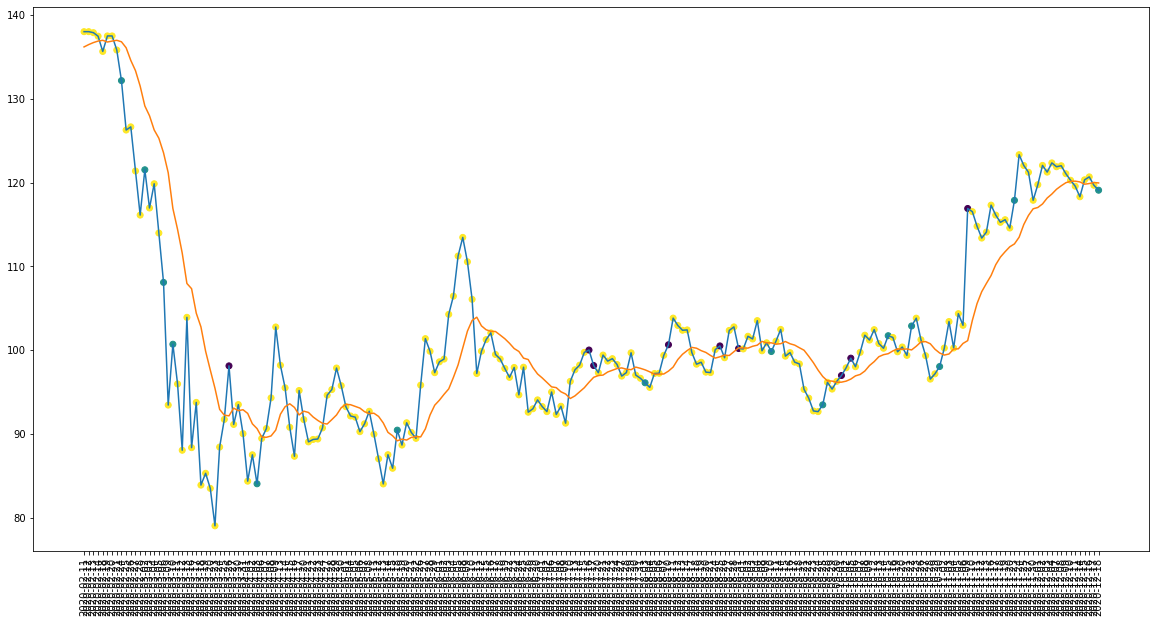

In [173]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

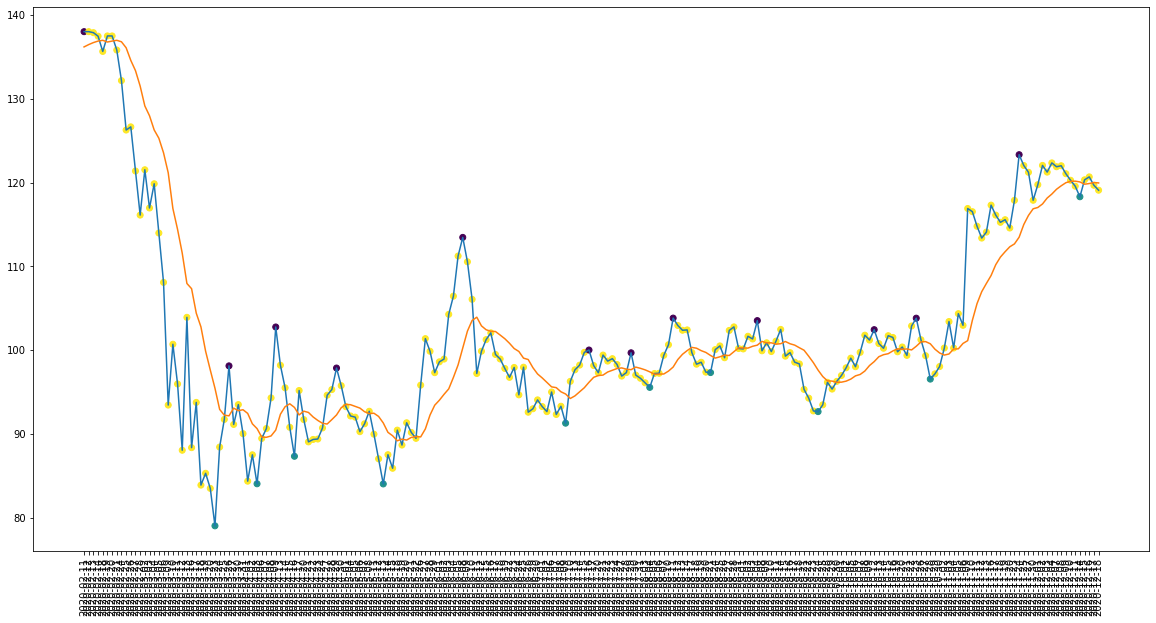

In [174]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [175]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 1
actual buys but predicted sell: 0
actual buys but predicted hold: 9
actual sells but predicted buy: 0
actual predicted sells: 2
actual sells but predicted hold: 10
actual holds but predicted buy: 13
actual holds but predicted sell: 7
actual predicted holds: 177
Percentage buys correct: 10.0%
Percentage sells correct: 16.666666666666668%
Percentage holds correct: 89.84771573604061%
actual buys: 10
actual sells: 12
actual holds: 197


In [176]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[132.16000366210938, 135.63999938964844, 135.80999755859378, 137.46000671386722, 137.49000549316406, 137.49000549316406, 137.8800048828125, 138.0, 138.0]
[116.11000061035156, 116.95999908447266, 121.37000274658205, 121.5199966430664, 126.26000213623048, 126.63999938964844, 132.16000366210938, 135.80999755859378, 137.49000549316406]
Percentage buys correct: 42.857142857142854%
Percentage sells correct: 55.55555555555556%
Percentage holds correct: 82.56410256410257%


In [177]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $132.16000366210938
Shares owned at the moment: 75
Cash capital at the moment: $60.74172458648718


Stop Loss Activated!

Share price: $126.26000213623048
Shares owned at the moment: 0
Cash capital at the moment: $9504.200759363177


Share price: $121.5199966430664
Shares owned at the moment: 77
Cash capital at the moment: $121.42915855789397


Stop Loss Activated!

Share price: $116.95999908447266
Shares owned at the moment: 0
Cash capital at the moment: $9102.582808256151


Share price: $108.08000183105469
Shares owned at the moment: 83
Cash capital at the moment: $107.27339586067319


Stop Loss Activated!

Share price: $93.44000244140624
Shares owned at the moment: 0
Cash capital at the moment: $7841.46591794014


Share price: $100.6999969482422
Shares owned at the moment: 77
Cash capital at the moment: $66.24292857169985


Stop Loss Activated!

Share price: $95.95999908447266
Shares owned at the moment: 0
Cash capital at the moment: $7434.843328269957


Share price: $8

In [178]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $8586.858291473387
profit gained: -14.13141708526613%


## American Axle & Manufacturing Holdings, Inc

In [179]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data.csv")
print(df.head())

         Date  previous_1d     EMA_12   willr_14     OBV_7  labels
0  2000-01-21      16.0625  14.895987 -18.478261  298700.0     2.0
1  2000-01-24      15.8750  15.046605 -22.222222  293100.0     2.0
2  2000-01-25      15.7500  15.154819 -26.190476  286300.0     2.0
3  2000-01-26      15.7500  15.246386 -29.729730  286300.0     2.0
4  2000-01-27      16.0000  15.362326 -25.000000  311700.0     0.0


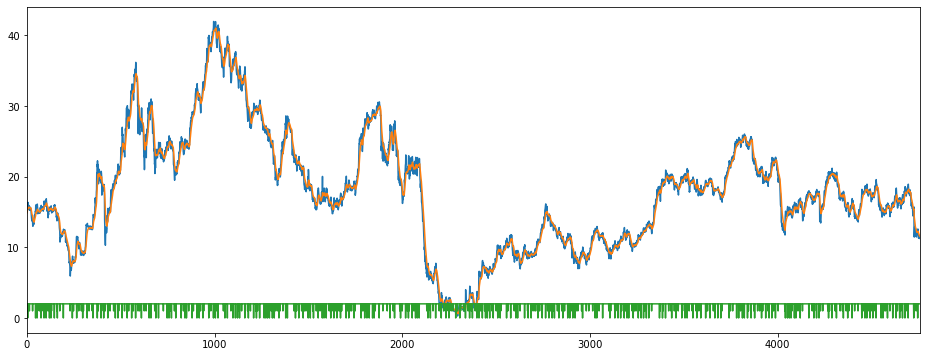

In [180]:
#%matplotlib notebook
df['previous_1d'].plot(figsize=(16,6),x='Date', y='Close')
df['EMA_12'].plot(figsize=(16,6),x='Date', y='EMA')
df['labels'].plot(figsize=(16,6),x='Date', y='labels')

In [181]:
df.set_index('Date', inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2000-01-21,16.0625,14.895987,-18.478261,298700.0,2.0
2000-01-24,15.8750,15.046605,-22.222222,293100.0,2.0
2000-01-25,15.7500,15.154819,-26.190476,286300.0,2.0
2000-01-26,15.7500,15.246386,-29.729730,286300.0,2.0
2000-01-27,16.0000,15.362326,-25.000000,311700.0,0.0


In [182]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(4755, 5, 4)

In [183]:
from sklearn import model_selection

X_train, X_test, y_train, y_test = model_selection.train_test_split(X,
                                                                    y,
                                                                    test_size = 0.2,
                                                                    random_state=seed,stratify=y)

In [184]:
import time

SEQ_LEN = 15  # how long of a preceeding sequence to collect for RNN
FUTURE_PERIOD_PREDICT = 1  # how far into the future are we trying to predict?
EPOCHS = 200  # how many passes through our data
BATCH_SIZE = 128  # how many batches? Try smaller batch if you're getting OOM (out of memory) errors.
NAME = f"{SEQ_LEN}-SEQ-{FUTURE_PERIOD_PREDICT}-PRED-{int(time.time())}"  # a unique name for the model

In [185]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 3)
y_test = to_categorical(y_test, 3)

In [186]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, LSTM, BatchNormalization,Activation
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D
# more info on callbakcs: https://keras.io/callbacks/ model saver is cool too.
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle
import time
import random

seed = 10
os.environ['PYTHONHASHSEED']=str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
random.seed(seed)

model = Sequential()

model.add(LSTM(100, input_shape=(X_train.shape[1:]), return_sequences=True,kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

model.add(LSTM(100, kernel_regularizer=l2(1e-5)))
model.add(BatchNormalization())
model.add(Activation('relu'))

# model.add(Dense(100, kernel_regularizer=l2(1e-5)))
# model.add(Activation('relu'))

model.add(Dense(75, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(50, kernel_regularizer=l2(1e-5)))
model.add(Activation('relu'))

model.add(Dense(3, use_bias=True, activation=None))

In [187]:
from sklearn.utils.class_weight import compute_class_weight
import tensorflow_addons as tfa
opt = tf.keras.optimizers.Adam(lr=1e-4)

# Compile model
model.compile(
    loss=tfa.losses.SigmoidFocalCrossEntropy(from_logits=True,reduction=tf.keras.losses.Reduction.AUTO),
    optimizer=opt,
    metrics=['accuracy','mse'],
    weighted_metrics=['accuracy','mse']
)

#tensorboard = TensorBoard(log_dir="logs/{}".format(NAME))

filepath = "LSTM_Final-{epoch:02d}-{val_accuracy:.3f}"  # unique file name that will include the epoch and the validation acc for that epoch
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')) # saves only the best ones

train_x = X_train
train_y = y_train
validation_x = X_test
validation_y = y_test

y_integers = np.argmax(train_y, axis=1)
class_weights = compute_class_weight('balanced', np.unique(y_integers), y_integers)
d_class_weights = dict(enumerate(class_weights))

# Train model
history = model.fit(
    train_x, train_y,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    shuffle = True,
    validation_data=(validation_x, validation_y),
    #callbacks=[tensorboard],
    class_weight=d_class_weights
)

C:\Users\Shearman Chua\anaconda3\lib\site-packages\sklearn\utils\validation.py:68: FutureWarning: Pass classes=[0 1 2], y=[2 2 2 ... 1 2 1] as keyword args. From version 0.25 passing these as positional arguments will result in an error
  warnings.warn("Pass {} as keyword args. From version 0.25 "


Epoch 1/200
30/30 [==============================] - 1s 29ms/step - loss: 0.2675 - accuracy: 0.4409 - mse: 0.4621 - weighted_accuracy: 0.3687 - weighted_mse: 0.4877 - val_loss: 0.3005 - val_accuracy: 0.0463 - val_mse: 0.3474 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3474
Epoch 2/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1986 - accuracy: 0.2674 - mse: 0.8036 - weighted_accuracy: 0.5208 - weighted_mse: 0.7440 - val_loss: 0.2912 - val_accuracy: 0.0463 - val_mse: 0.3698 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3698
Epoch 3/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1780 - accuracy: 0.2424 - mse: 1.0583 - weighted_accuracy: 0.5570 - weighted_mse: 0.9906 - val_loss: 0.2792 - val_accuracy: 0.0463 - val_mse: 0.3974 - val_weighted_accuracy: 0.0463 - val_weighted_mse: 0.3974
Epoch 4/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1697 - accuracy: 0.2350 - mse: 1.2475 - weighted_accuracy: 0.5779 - weighte

Epoch 30/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1343 - accuracy: 0.4345 - mse: 1.7455 - weighted_accuracy: 0.7182 - weighted_mse: 1.6699 - val_loss: 0.1954 - val_accuracy: 0.3649 - val_mse: 1.7238 - val_weighted_accuracy: 0.3649 - val_weighted_mse: 1.7238
Epoch 31/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1336 - accuracy: 0.4422 - mse: 1.7392 - weighted_accuracy: 0.7246 - weighted_mse: 1.6609 - val_loss: 0.1882 - val_accuracy: 0.4080 - val_mse: 1.6703 - val_weighted_accuracy: 0.4080 - val_weighted_mse: 1.6703
Epoch 32/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1323 - accuracy: 0.4658 - mse: 1.7267 - weighted_accuracy: 0.7315 - weighted_mse: 1.6618 - val_loss: 0.1997 - val_accuracy: 0.3554 - val_mse: 1.7538 - val_weighted_accuracy: 0.3554 - val_weighted_mse: 1.7538
Epoch 33/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1325 - accuracy: 0.4380 - mse: 1.7666 - weighted_accuracy: 0.7158 - weig

Epoch 59/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1124 - accuracy: 0.5647 - mse: 2.1395 - weighted_accuracy: 0.7877 - weighted_mse: 2.0649 - val_loss: 0.1726 - val_accuracy: 0.5405 - val_mse: 2.1316 - val_weighted_accuracy: 0.5405 - val_weighted_mse: 2.1316
Epoch 60/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1110 - accuracy: 0.5607 - mse: 2.1519 - weighted_accuracy: 0.7935 - weighted_mse: 2.0899 - val_loss: 0.1718 - val_accuracy: 0.5321 - val_mse: 2.1538 - val_weighted_accuracy: 0.5321 - val_weighted_mse: 2.1538
Epoch 61/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1110 - accuracy: 0.5634 - mse: 2.1672 - weighted_accuracy: 0.7999 - weighted_mse: 2.0892 - val_loss: 0.1821 - val_accuracy: 0.4784 - val_mse: 2.2886 - val_weighted_accuracy: 0.4784 - val_weighted_mse: 2.2886
Epoch 62/200
30/30 [==============================] - 0s 6ms/step - loss: 0.1103 - accuracy: 0.5849 - mse: 2.2031 - weighted_accuracy: 0.8060 - weig

Epoch 88/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0914 - accuracy: 0.6753 - mse: 2.7588 - weighted_accuracy: 0.8573 - weighted_mse: 2.6794 - val_loss: 0.1630 - val_accuracy: 0.6288 - val_mse: 2.7417 - val_weighted_accuracy: 0.6288 - val_weighted_mse: 2.7417
Epoch 89/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0901 - accuracy: 0.6688 - mse: 2.7579 - weighted_accuracy: 0.8622 - weighted_mse: 2.6624 - val_loss: 0.1591 - val_accuracy: 0.6625 - val_mse: 2.7923 - val_weighted_accuracy: 0.6625 - val_weighted_mse: 2.7923
Epoch 90/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0906 - accuracy: 0.6964 - mse: 2.7619 - weighted_accuracy: 0.8559 - weighted_mse: 2.6838 - val_loss: 0.1817 - val_accuracy: 0.5647 - val_mse: 2.8600 - val_weighted_accuracy: 0.5647 - val_weighted_mse: 2.8600
Epoch 91/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0902 - accuracy: 0.6898 - mse: 2.7562 - weighted_accuracy: 0.8644 - weig

Epoch 117/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0727 - accuracy: 0.7710 - mse: 3.6420 - weighted_accuracy: 0.9033 - weighted_mse: 3.4560 - val_loss: 0.1864 - val_accuracy: 0.6172 - val_mse: 3.9865 - val_weighted_accuracy: 0.6172 - val_weighted_mse: 3.9865
Epoch 118/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0722 - accuracy: 0.7476 - mse: 3.6803 - weighted_accuracy: 0.8983 - weighted_mse: 3.5301 - val_loss: 0.1792 - val_accuracy: 0.6393 - val_mse: 3.9434 - val_weighted_accuracy: 0.6393 - val_weighted_mse: 3.9434
Epoch 119/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0744 - accuracy: 0.7453 - mse: 3.7262 - weighted_accuracy: 0.8884 - weighted_mse: 3.5598 - val_loss: 0.1781 - val_accuracy: 0.6435 - val_mse: 3.8090 - val_weighted_accuracy: 0.6435 - val_weighted_mse: 3.8090
Epoch 120/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0742 - accuracy: 0.7563 - mse: 3.8322 - weighted_accuracy: 0.8979 - 

Epoch 146/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0616 - accuracy: 0.8005 - mse: 4.9070 - weighted_accuracy: 0.9123 - weighted_mse: 4.5526 - val_loss: 0.1863 - val_accuracy: 0.6845 - val_mse: 4.9420 - val_weighted_accuracy: 0.6845 - val_weighted_mse: 4.9420
Epoch 147/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0589 - accuracy: 0.8268 - mse: 4.9062 - weighted_accuracy: 0.9310 - weighted_mse: 4.5492 - val_loss: 0.1787 - val_accuracy: 0.7245 - val_mse: 5.5906 - val_weighted_accuracy: 0.7245 - val_weighted_mse: 5.5906
Epoch 148/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0573 - accuracy: 0.8141 - mse: 4.9670 - weighted_accuracy: 0.9282 - weighted_mse: 4.5745 - val_loss: 0.1724 - val_accuracy: 0.7224 - val_mse: 5.1904 - val_weighted_accuracy: 0.7224 - val_weighted_mse: 5.1904
Epoch 149/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0580 - accuracy: 0.8260 - mse: 5.0042 - weighted_accuracy: 0.9271 - 

Epoch 175/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0476 - accuracy: 0.8667 - mse: 6.4588 - weighted_accuracy: 0.9456 - weighted_mse: 5.7932 - val_loss: 0.1972 - val_accuracy: 0.7056 - val_mse: 6.4488 - val_weighted_accuracy: 0.7056 - val_weighted_mse: 6.4488
Epoch 176/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0490 - accuracy: 0.8599 - mse: 6.5014 - weighted_accuracy: 0.9377 - weighted_mse: 5.8789 - val_loss: 0.2143 - val_accuracy: 0.6856 - val_mse: 6.7942 - val_weighted_accuracy: 0.6856 - val_weighted_mse: 6.7942
Epoch 177/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0485 - accuracy: 0.8533 - mse: 6.5870 - weighted_accuracy: 0.9353 - weighted_mse: 5.9575 - val_loss: 0.1795 - val_accuracy: 0.7792 - val_mse: 7.4592 - val_weighted_accuracy: 0.7792 - val_weighted_mse: 7.4592
Epoch 178/200
30/30 [==============================] - 0s 6ms/step - loss: 0.0478 - accuracy: 0.8575 - mse: 6.7364 - weighted_accuracy: 0.9405 - 

In [188]:
# Score model
score = model.evaluate(validation_x, validation_y, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.21736638247966766
Test accuracy: 0.7171398401260376


In [189]:
predictions = model.predict(validation_x)
print(predictions)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]
from collections import Counter

Counter(predictions)

[[-2.0815716  -1.3996485   0.1304686 ]
 [-1.1659977  -1.7881048   0.7382387 ]
 [-0.49242467 -4.9030223   0.00918203]
 ...
 [-2.4049249  -1.3603536   0.6492145 ]
 [-2.3066125  -4.9705863   1.9021845 ]
 [-2.125962   -5.964478    1.6910857 ]]


Counter({2: 723, 0: 99, 1: 129})

In [190]:
actual = [np.argmax(i, axis=None, out=None) for i in validation_y]
Counter(actual)

Counter({2: 864, 0: 43, 1: 44})

In [191]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 951
actual predicted buys: 12
actual buys but predicted sell: 1
actual buys but predicted hold: 31
actual sells but predicted buy: 1
actual predicted sells: 10
actual sells but predicted hold: 32
actual holds but predicted buy: 116
actual holds but predicted sell: 88
actual predicted holds: 660
Percentage buys correct: 27.272727272727273%
Percentage sells correct: 23.25581395348837%
Percentage holds correct: 76.38888888888889%
actual buys: 44
actual sells: 43
actual holds: 864


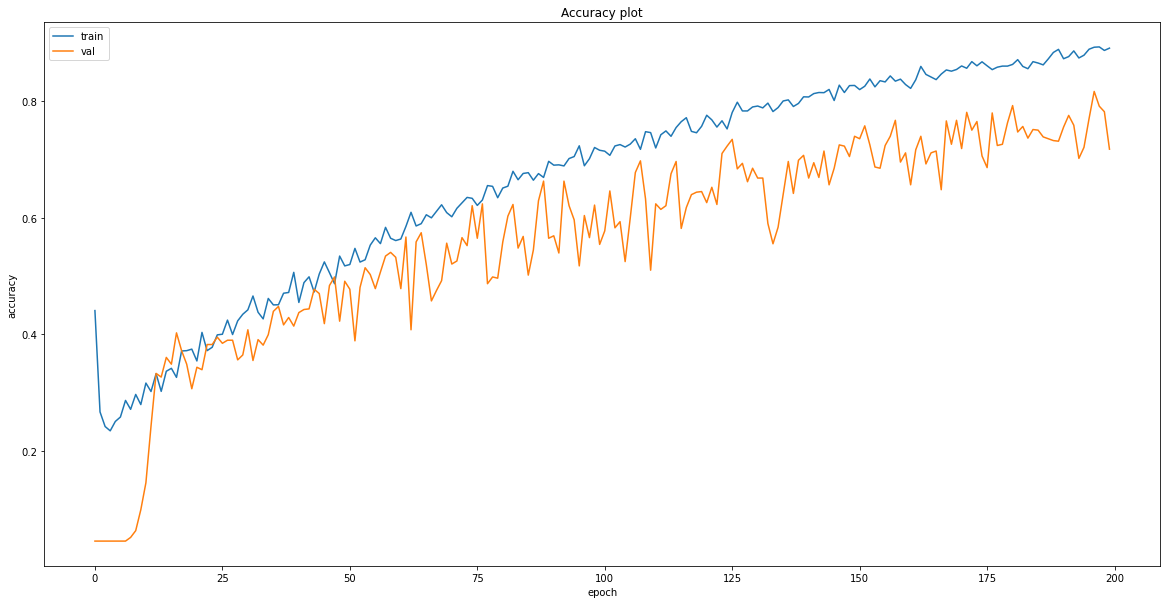

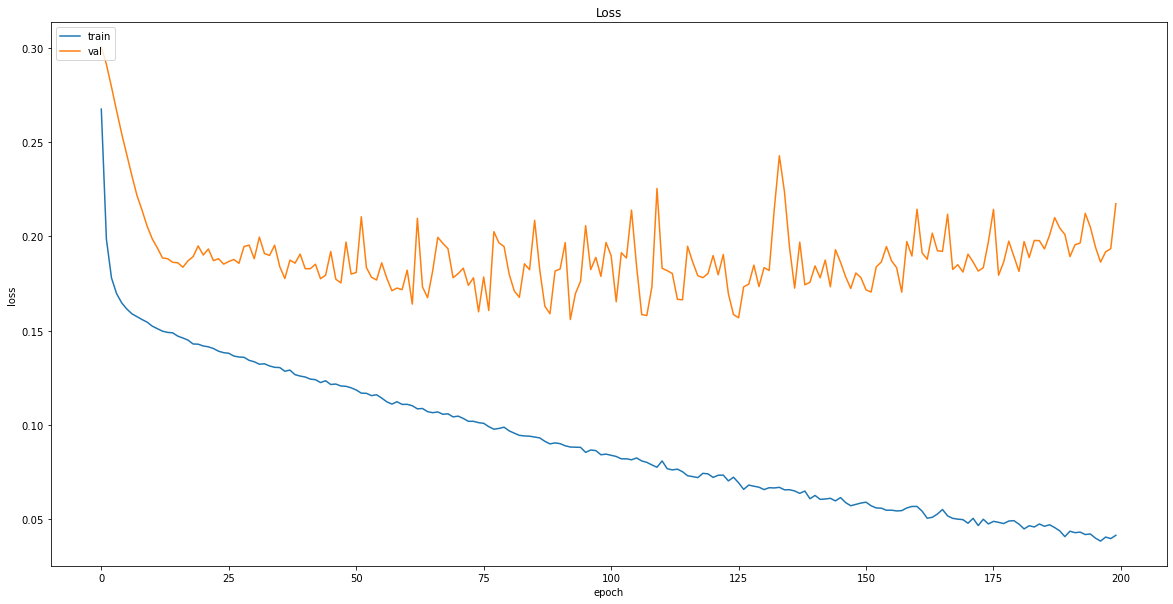

In [192]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy plot')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [193]:
# Save model
model.save("models/{}".format('axl_time_series_lstm_buy_hold_sell_5.model'))

INFO:tensorflow:Assets written to: models/axl_time_series_lstm_buy_hold_sell_5.model\assets


### Test Performance

### non-recession

In [194]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2019-02-05,15.20,14.400475,-0.000000,24810300.0,2.0
2019-02-06,14.87,14.472709,-25.974048,23696400.0,2.0
2019-02-07,14.59,14.490754,-44.155838,21810900.0,2.0
2019-02-08,14.00,14.415253,-81.935503,19302900.0,1.0
2019-02-11,13.75,14.312907,-83.060094,17347800.0,2.0


In [195]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(218, 5, 4)

In [196]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [197]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 3ms/step - loss: 0.2111 - accuracy: 0.7202 - mean_squared_error: 7.9546 - weighted_accuracy: 0.7202 - weighted_mean_squared_error: 7.9546
Test loss: 0.21113011240959167
Test accuracy: 0.7201834917068481


In [198]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 165, 1: 35, 0: 18})

In [199]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [200]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2019-02-11,14.01,14.312907,-83.060094,17347800.0,2.0,2,2
2019-02-12,14.34,14.266306,-68.852439,19189100.0,2.0,2,2
2019-02-13,14.45,14.277643,-50.819664,21493700.0,2.0,2,2
2019-02-14,14.70,14.304160,-44.808757,23008200.0,2.0,2,2
2019-02-15,16.83,14.365058,-31.147561,25735200.0,2.0,2,2


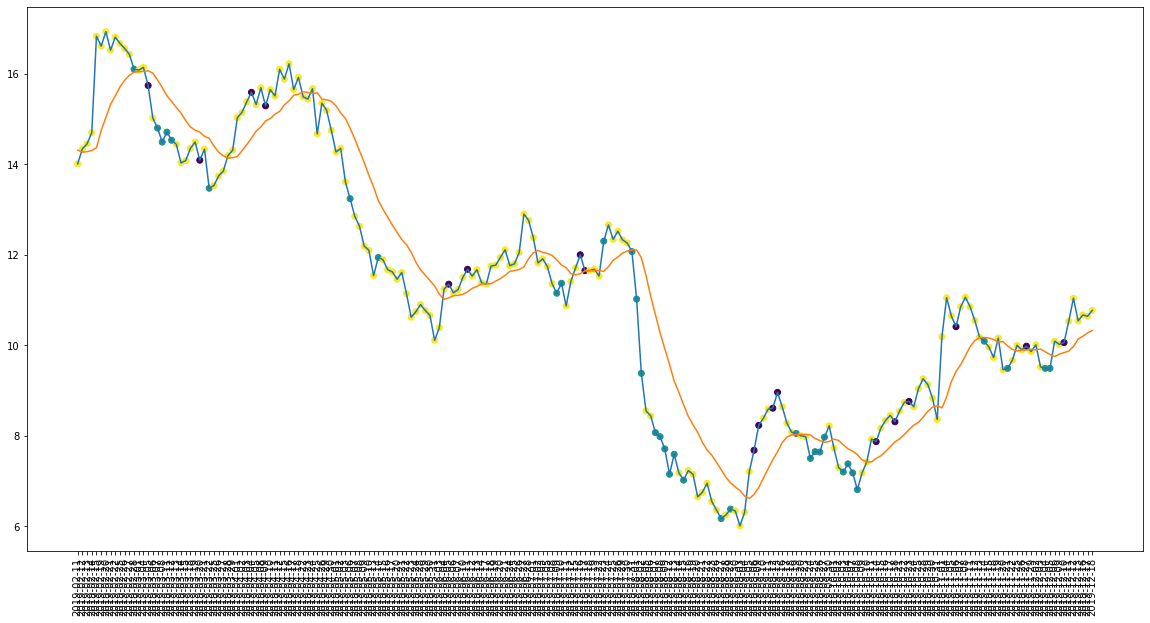

In [201]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

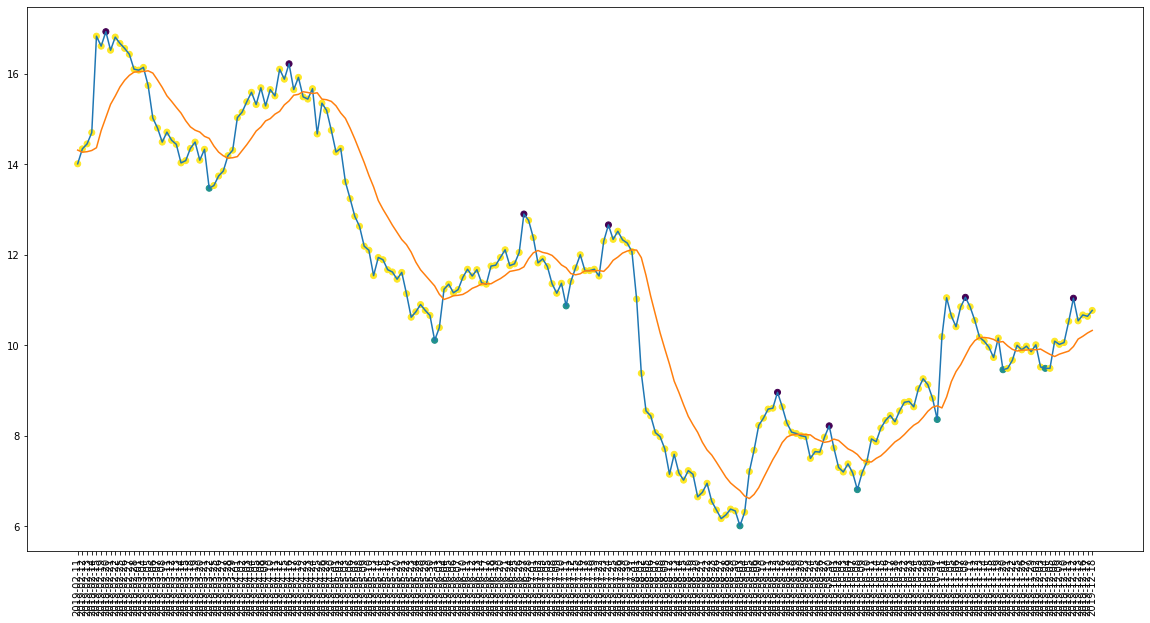

In [202]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [203]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 218
actual predicted buys: 3
actual buys but predicted sell: 0
actual buys but predicted hold: 5
actual sells but predicted buy: 0
actual predicted sells: 1
actual sells but predicted hold: 7
actual holds but predicted buy: 32
actual holds but predicted sell: 17
actual predicted holds: 153
Percentage buys correct: 37.5%
Percentage sells correct: 12.5%
Percentage holds correct: 75.74257425742574%
actual buys: 8
actual sells: 8
actual holds: 202


In [204]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[14.010000228881836, 14.34000015258789, 14.449999809265135, 14.699999809265135, 16.520000457763672, 16.610000610351562, 16.809999465942386, 16.829999923706055, 16.930000305175778]
[16.079999923706055, 16.100000381469727, 16.139999389648438, 16.430000305175778, 16.520000457763672, 16.559999465942386, 16.670000076293945, 16.809999465942386, 16.930000305175778]
Percentage buys correct: 51.42857142857143%
Percentage sells correct: 50.0%
Percentage holds correct: 86.58536585365853%


In [205]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $16.100000381469727
Shares owned at the moment: 619
Cash capital at the moment: $6.693538220881237


Stop Loss Activated!

Share price: $15.020000457763672
Shares owned at the moment: 0
Cash capital at the moment: $9278.506025797366


Share price: $14.800000190734865
Shares owned at the moment: 625
Cash capital at the moment: $3.0684062602485938


Stop Loss Activated!

Share price: $14.029999732971193
Shares owned at the moment: 0
Cash capital at the moment: $8747.7041773262


Share price: $13.470000267028807
Shares owned at the moment: 647
Cash capital at the moment: $8.647506583452923


Price increase from previously bought: 15.421268893855045%
Share price: $15.59000015258789
Shares owned at the moment: 0
Cash capital at the moment: $10067.639097536327


Share price: $13.239999771118164
Shares owned at the moment: 758
Cash capital at the moment: $4.1204915058624465


Stop Loss Activated!

Share price: $12.850000381469727
Shares owned at the moment: 0
Cash capital at the 

In [206]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7647.909066392421
profit gained: -23.520909336075793%


### recession

In [207]:
seed = 10
df = pd.read_csv("data/cyclic_tickers/initial_indicators/AXL_data_test2.csv")
df.set_index('Date', inplace=True)
df = df.iloc[10:]
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels
Date,,,,,
2020-02-05,9.80,9.521652,-19.444449,-1562200.0,2.0
2020-02-06,10.18,9.622936,-13.194419,9300.0,2.0
2020-02-07,9.85,9.657869,-36.111087,-1326200.0,2.0
2020-02-10,9.69,9.662812,-47.222257,-2311300.0,2.0
2020-02-11,9.54,9.643918,-57.638900,-3274300.0,2.0


In [208]:
labels = []
data_5 = []
sequential = []
count = 0

for i in df.values:
    if count == 4:
        data_5.append(np.array(i[0:-1]))
        labels.append(i[-1])
        min_max_scaler = preprocessing.MinMaxScaler()
        data_5_arr = min_max_scaler.fit_transform(data_5)
        sequential.append(data_5_arr)
        data_5 = data_5[1:5]
    else:
        data_5.append(np.array(i[0:-1]))
        count+= 1
        
X = sequential
X  = np.array(X).reshape(-1, 5, 4)
y = labels
y = np.array(y)
X.shape

(219, 5, 4)

In [209]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 3)

In [210]:
model = tf.keras.models.load_model("models/axl_time_series_lstm_buy_hold_sell_5.model")
score = model.evaluate(X, y)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

7/7 [==============================] - 0s 2ms/step - loss: 0.1829 - accuracy: 0.7489 - mean_squared_error: 7.8906 - weighted_accuracy: 0.7489 - weighted_mean_squared_error: 7.8906
Test loss: 0.18287137150764465
Test accuracy: 0.7488584518432617


In [211]:
from collections import Counter

predictions = model.predict(X)
predictions = [np.argmax(y, axis=None, out=None) for y in predictions]

Counter(predictions)

Counter({2: 171, 0: 21, 1: 27})

In [212]:
actual = [np.argmax(i, axis=None, out=None) for i in y]

In [213]:
df = df.iloc[4:]
df['predictions'] = predictions
df['actual'] = actual
df['previous_1d'] = df['previous_1d'].shift(-1)
df.dropna(inplace=True)
df.head()

,previous_1d,EMA_12,willr_14,OBV_7,labels,predictions,actual
Date,,,,,,,
2020-02-11,9.84,9.643918,-57.638900,-3274300.0,2.0,2,2
2020-02-12,10.34,9.674085,-36.805548,-1876100.0,0.0,2,0
2020-02-13,10.22,9.776533,-16.568036,-291400.0,2.0,2,2
2020-02-14,8.77,9.844759,-23.668622,-1567700.0,2.0,0,2
2020-02-18,8.27,9.679411,-90.686248,-6644000.0,2.0,2,2


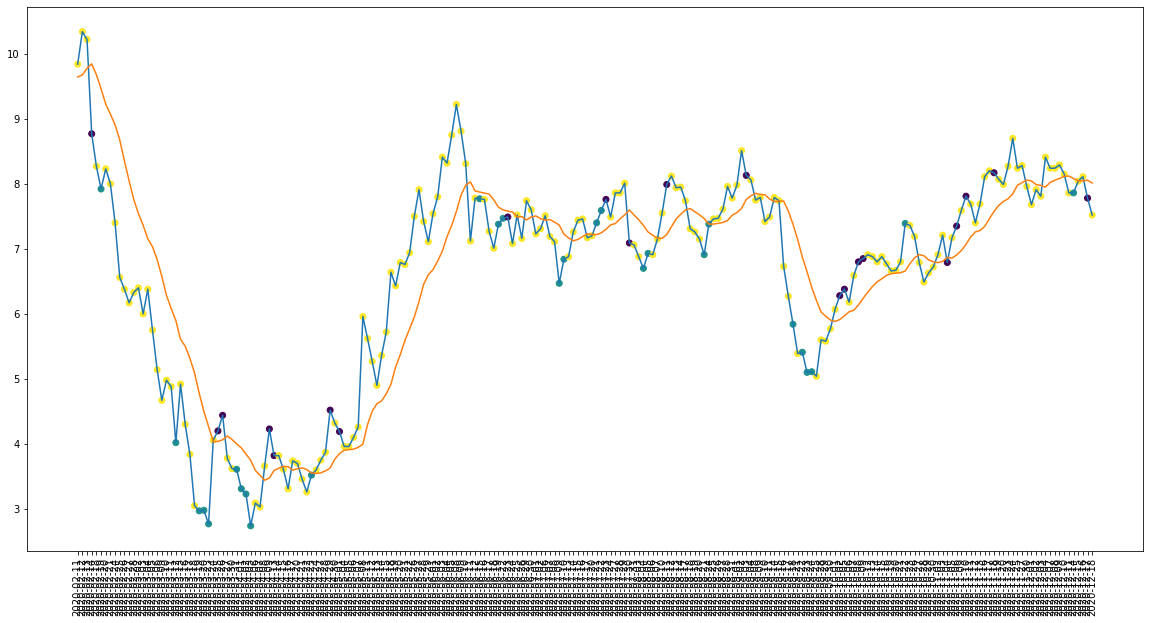

In [214]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['predictions'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

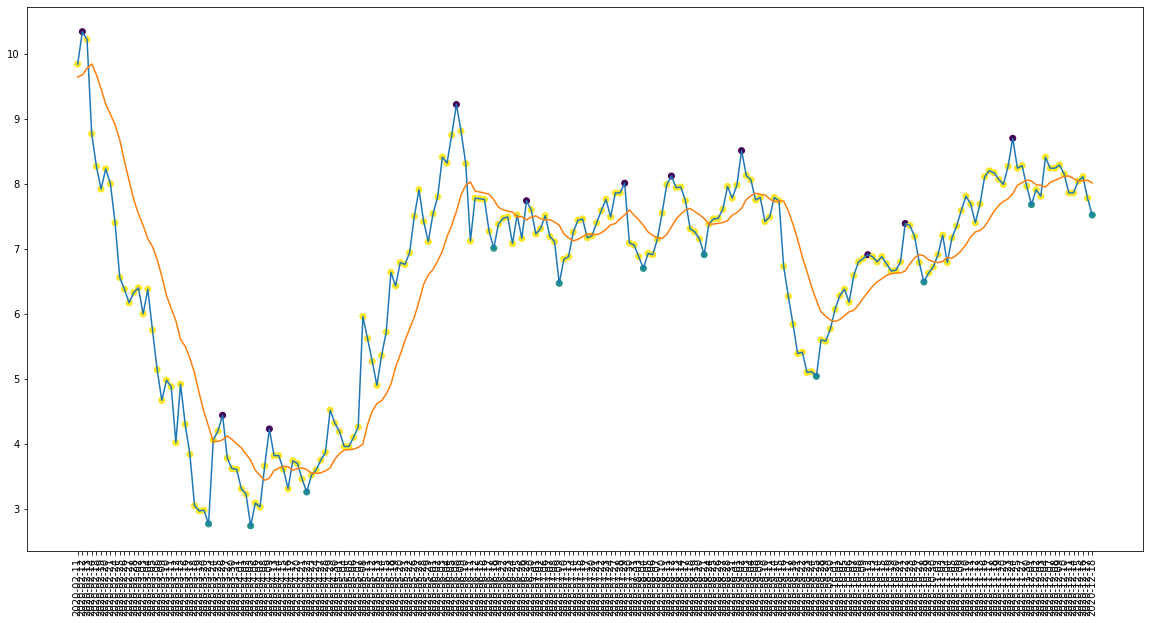

In [215]:
import matplotlib.pyplot as plt
import numpy as np

y = df['previous_1d'].values
x = df.index.values
c = df['actual'].values

# plot the data
plt.figure(figsize=(20,10))
plt.plot(df['previous_1d'].values)
plt.plot(df['EMA_12'].values)
#plt.plot(df['willr_6'].values)
plt.scatter(x, y, c=c,label=c)
plt.xticks(rotation=90)
plt.show()

In [216]:
hold = 0
sell = 0
buy = 0
buy_buy = 0
buy_sell = 0
buy_hold = 0
sell_buy = 0
sell_sell = 0
sell_hold = 0
hold_buy = 0
hold_sell = 0
hold_hold = 0

for i in range (0,len(actual)):
    if actual[i]==1 and predictions[i] == 1:
        buy_buy += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 0:
        buy_sell += 1
        buy += 1
    elif actual[i]==1 and predictions[i] == 2:
        buy_hold += 1
        buy += 1
    elif actual[i]==0 and predictions[i] == 1:
        sell_buy += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 0:
        sell_sell += 1
        sell += 1
    elif actual[i]==0 and predictions[i] == 2:
        sell_hold += 1
        sell += 1
    elif actual[i]==2 and predictions[i] == 1:
        hold_buy += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 0:
        hold_sell += 1
        hold += 1
    elif actual[i]==2 and predictions[i] == 2:
        hold_hold += 1
        hold += 1
        
print("number of predictions: " + str(len(actual)))
print("actual predicted buys: " + str(buy_buy) )
print("actual buys but predicted sell: " + str(buy_sell) )
print("actual buys but predicted hold: " + str(buy_hold))
print("actual sells but predicted buy: " + str(sell_buy) )
print("actual predicted sells: " + str(sell_sell))
print("actual sells but predicted hold: " + str(sell_hold) )
print("actual holds but predicted buy: " + str(hold_buy) )
print("actual holds but predicted sell: " + str(hold_sell))
print("actual predicted holds: " + str(hold_hold) )

print("Percentage buys correct: " + str(100*buy_buy/buy) + "%")
print("Percentage sells correct: " + str(100*sell_sell/sell) + "%")
print("Percentage holds correct: " + str(100*hold_hold/hold) + "%")

print("actual buys: " + str(buy))
print("actual sells: " + str(sell))
print("actual holds: " + str(hold))

number of predictions: 219
actual predicted buys: 5
actual buys but predicted sell: 0
actual buys but predicted hold: 6
actual sells but predicted buy: 1
actual predicted sells: 2
actual sells but predicted hold: 8
actual holds but predicted buy: 21
actual holds but predicted sell: 19
actual predicted holds: 157
Percentage buys correct: 45.45454545454545%
Percentage sells correct: 18.181818181818183%
Percentage holds correct: 79.69543147208122%
actual buys: 11
actual sells: 11
actual holds: 197


In [217]:
correct_maxima = 0 
correct_minima = 0
correct_hold = 0

hold = 0
buy = 0
sell = 0

predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    if i < 4:
        prices = price[i:i+9]
        prices.sort(key = float)
        if i == 0:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
    else:
        prices = price[i:i+5]
        prices = prices + price[i-4:i] 
        prices.sort(key = float)
        if i == 10:
            print(prices)
        highest_1 = prices[-1]
        highest_2 = prices[-2]
        highest_3 = prices[-3]
        highest_4 = prices[-4]
        lowest_1 = prices[0]
        lowest_2 = prices[1]
        lowest_3 = prices[2]
        lowest_4 = prices[3]
        if predictions[i] == 0:
            sell += 1
            if price[i] == highest_1 or price[i] == highest_2 or price[i] == highest_3 or price[i] == highest_4:
                correct_maxima += 1
        elif predictions[i] == 1:
            buy += 1
            if price[i] == lowest_1 or price[i] == lowest_2 or price[i] == lowest_3 or price[i] == lowest_4:
                correct_minima += 1
        elif predictions[i] == 2:
            hold += 1
            if price[i] != lowest_1 and price[i] != highest_1:
                correct_hold += 1
                
print("Percentage buys correct: " + str(100*correct_minima/buy) + "%")
print("Percentage sells correct: " + str(100*correct_maxima/sell) + "%")
print("Percentage holds correct: " + str(100*correct_hold/hold) + "%")

[7.400000095367432, 7.920000076293945, 8.0, 8.229999542236326, 8.270000457763674, 8.770000457763674, 9.84000015258789, 10.220000267028807, 10.34000015258789]
[6.0, 6.170000076293945, 6.329999923706055, 6.380000114440918, 6.4000000953674325, 6.559999942779541, 7.400000095367432, 8.0, 8.229999542236326]
Percentage buys correct: 66.66666666666667%
Percentage sells correct: 80.95238095238095%
Percentage holds correct: 86.47058823529412%


In [218]:
from sklearn.preprocessing import MinMaxScaler
import math

capital = 10000
shares = 0

previously_buy = False
previously_sell = False
prev_buy_price = 0
bought_once = False


predictions = df['predictions'].values.tolist()
price = df['previous_1d'].values.tolist()

for i in range(0,len(predictions)):
    
    if  bought_once==True and (1-price[i]/prev_buy_price)*100 >= 3 and shares!=0:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Stop Loss Activated!\n")
#         print(i)
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
    
    if predictions[i] == 1 and previously_buy != True:
        shares = math.floor(capital / (price[i]*1.00275))
        capital = capital - shares*price[i]*1.00275
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        prev_buy_price = price[i]*1.00275
        bought_once = True
        previously_buy = True
        previously_sell = False
        
    elif predictions[i] == 0 and previously_sell != True and shares!=0 and (price[i]/prev_buy_price-1)*100 >= 5:
        capital += 0.99725 * (shares*price[i])
        shares = 0
        print("Price increase from previously bought: " + str((price[i]/prev_buy_price-1)*100 ) + '%')
        print("Share price: $" + str(price[i]))
        print("Shares owned at the moment: " + str(shares))
        print("Cash capital at the moment: $" + str(capital))
        print("\n")
        previously_buy = False
        previously_sell = True
        
if shares!=0:
    capital += 0.99725 * (shares*price[i])
    
print('\n')
print("Capital at the end of test period: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')

Share price: $7.920000076293945
Shares owned at the moment: 1259
Cash capital at the moment: $1.2988836817730771


Stop Loss Activated!

Share price: $7.400000095367432
Shares owned at the moment: 0
Cash capital at the moment: $9292.278353419184


Share price: $4.019999980926514
Shares owned at the moment: 2305
Cash capital at the moment: $0.6966225044725434


Stop Loss Activated!

Share price: $3.839999914169312
Shares owned at the moment: 0
Cash capital at the moment: $8827.555625208797


Share price: $2.970000028610228
Shares owned at the moment: 2964
Cash capital at the moment: $0.2670701748775173


Stop Loss Activated!

Share price: $2.7699999809265137
Shares owned at the moment: 0
Cash capital at the moment: $8187.968743796532


Share price: $2.7699999809265137
Shares owned at the moment: 2947
Cash capital at the moment: $2.3300276606723855


Price increase from previously bought: 51.208718917749586%
Share price: $4.199999809265137
Shares owned at the moment: 0
Cash capital at th

In [219]:
capital = 10000
shares = 0

shares = math.floor(capital / (price[0]*1.00275))
capital = capital - shares*price[0]*1.00275
capital += 0.99725 * (shares*price[-1])

print('\n')
print("Capital at the end of test period if Buy and Hold: $" +str(capital))
print("profit gained: " + str(((capital- 10000 )/ 10000) * 100 ) + '%')



Capital at the end of test period if Buy and Hold: $7601.479205735086
profit gained: -23.98520794264914%
